In [1]:
import os
import textwrap  
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.patches import Rectangle
from scipy import stats
from scipy.stats import spearmanr
from sklearn.utils import resample
from statsmodels.stats.inter_rater import cohens_kappa
from statsmodels.stats.outliers_influence import variance_inflation_factor
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from sklearn.metrics import f1_score
import textwrap
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests
from scipy.stats import kendalltau
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import multipletests



In [2]:
### CLEANING DATA

### EPITOME
epitome = pd.read_csv("original_data/sample_epitome.csv")
epitome = epitome[
    [
        "sp_id",
        "rp_id",
        "level_emotional_reactions",
        "level_explorations",
        "level_interpretations",
        "response_length"
    ]
]
epitome.to_csv("annotations/epitome/sample_ratings_crowdsourced.csv", index=False)

### PERCEIVED EMPATHY
perceived_empathy = pd.read_csv(
    "original_data/sample_perceived_empathy_annotations.csv"
)
perceived_empathy = perceived_empathy.rename(columns={"OriginalDiscloserID": "id"})
perceived_empathy = perceived_empathy[
    [
        "id",
        "m_understood",
        "m_validated",
        "m_affirmed",
        "m_seen",
        "m_accepted",
        "m_caredfor",
        "m_emotional",
        "m_practical",
        "m_motivation",
        "response_length"
    ]
]
perceived_empathy.to_csv(
    "annotations/perceived_empathy/sample_ratings_crowdsourced.csv", index=False
)

### EMPATHETIC DIALOGUES
empathetic_dialogues = pd.read_csv("original_data/sample_empatheticdialogues.csv")
empathetic_dialogues = empathetic_dialogues.drop_duplicates(subset=["conv_id"])
empathetic_dialogues["empathy"] = pd.to_numeric(
    empathetic_dialogues[["empathy1", "empathy2"]].mean(axis=1), errors='coerce'
)
empathetic_dialogues["fluency"] = pd.to_numeric(
    empathetic_dialogues[["fluency1", "fluency2"]].mean(axis=1), errors='coerce'
)
empathetic_dialogues["relevance"] = pd.to_numeric(
    empathetic_dialogues[["relevance1", "relevance2"]].mean(axis=1), errors='coerce'
)
empathetic_dialogues = empathetic_dialogues[
    ["conv_id", "empathy", "fluency", "relevance", "response_length"]
]
empathetic_dialogues.to_csv(
    "annotations/empatheticdialogues/sample_ratings_crowdsourced.csv", index=False
)

### RPG
rpg = pd.read_csv("original_data/sample_lend_an_ear_annotations.csv")
rpg = rpg.drop(
    columns=[
        "user_id",
        "id",
        "validating_emotions_example",
        "encouraging_elaboration_example",
        "demonstrating_understanding_example",
        "self_oriented_example",
        "advice_giving_example",
        "dismissing_emotions_example",
        "time_created",
        "response_length"
    ]
)
rpg_mean = rpg.groupby("conversation_id").mean(numeric_only=True).reset_index()
rpg_mean.to_csv("annotations/lend_an_ear/sample_ratings_crowdsourced.csv", index=False)

In [3]:
# List of base files containing ratings and annotations from different sources
base_files = [
    "expert1_ratings.csv",  # Ratings from the first expert
    "expert2_ratings.csv",  # Ratings from the second expert
    "expert3_ratings.csv",
    "gemini_ratings.csv", #gemini
    "gpt_ratings.csv", #gpt-4o    
    "claude_ratings.csv", #claude
    "crowd_ratings.csv",  # Crowdsourced ratings
]

# Dictionary defining datasets with their respective file paths, sort columns, and dimensions
datasets = {
    "lend_an_ear": {
        "files": [
            f"annotations/lend_an_ear/{file}" for file in base_files
        ],  # File paths for Lend an ear dataset
        "sort_column": "conversation_id",
        "dimensions": [
            "validating_emotions",
            "encouraging_elaboration",
            "demonstrating_understanding",
            "advice_giving",
            "self_oriented",
            "dismissing_emotions",
        ],  # Dimensions for Lend an ear dataset
    },
    "perceived_empathy": {
        "files": [
            f"annotations/perceived_empathy/{file}" for file in base_files
        ],  # File paths for Perceived Empathy dataset
        "sort_column": "id",
        "dimensions": [
            "m_understood",
            "m_validated",
            "m_affirmed",
            "m_seen",
            "m_accepted",
            "m_caredfor",
            "m_emotional",
            "m_practical",
            "m_motivation",
        ],  # Dimensions for Perceived Empathy dataset
    },
    "empatheticdialogues": {
        "files": [
            f"annotations/empatheticdialogues/{file}" for file in base_files
        ],  # File paths for Empathetic Dialogues dataset
        "sort_column": "conv_id",
        "dimensions": [
            "empathy",
            "relevance",
            "fluency",
        ],  # Dimensions for Empathetic Dialogues dataset
    },
    "epitome": {
        "files": [
            f"annotations/epitome/{file}" for file in base_files
        ],  # File paths for Epitome dataset
        "sort_column": "sp_id",
        "dimensions": [
            "level_emotional_reactions",
            "level_explorations",
            "level_interpretations",
        ],  # Dimensions for Epitome dataset
    },
}


In [4]:
###COMBINING ANNOTATION DATA FROM ALL DATASETS
def order_by_column(df, column):
    try:
        return df.sort_values(by=column).reset_index(drop=True)
    except KeyError:
        print(f"Column '{column}' not found in DataFrame. Available columns: {df.columns.tolist()}")
        return df

def load_and_process(filepath, sort_column):
    df = pd.read_csv(filepath)
    return order_by_column(df, sort_column)


data = {}
# List of annotation methods corresponding to the files in each dataset
annotation_methods = ["expert1", "expert2", "expert3", "llm", "gpt", "claude", "crowd"]

for key in datasets.keys():
    for i in range(len(datasets[key]["files"])):
        data[key, annotation_methods[i]] = load_and_process(
            datasets[key]["files"][i], datasets[key]["sort_column"]
        )
        data[key, annotation_methods[i]]["annotation_method"] = annotation_methods[i]

median_expert_ratings = {}

for key in datasets.keys():
    expert1_df = data[key, "expert1"]
    expert2_df = data[key, "expert2"]
    expert3_df = data[key, "expert3"]
    median_df = expert1_df.copy() 
    
    # Calculate the median for each dimension and sample
    for dimension in datasets[key]["dimensions"]:
        # For each row/sample, get all three expert ratings and calculate median
        for idx in range(len(median_df)):
            experts_values = [
                expert1_df.iloc[idx][dimension],
                expert2_df.iloc[idx][dimension],
                expert3_df.iloc[idx][dimension]
            ]
            median_df.at[idx, dimension] = np.median(experts_values)
            
    median_expert_ratings[key] = median_df

for key in datasets.keys():
    median_expert_df = median_expert_ratings[key]
    # Set the annotation method to 'experts'
    median_expert_df["annotation_method"] = "experts"
    data[key, "experts"] = median_expert_df

data_combined = {}


# Concatenate data for all annotation methods within each dataset
for key in datasets.keys():
    data_combined[key] = pd.concat(
        data[key, annotation_methods[i]] for i in range(len(annotation_methods))
    )


# Add the 'experts' data to the combined data for each dataset
for key in datasets.keys():
    data_combined[key] = pd.concat([data_combined[key], data[key, "experts"]])


# Combine all datasets into a single DataFrame by concatenating along the columns
data_combined_all = pd.concat((data_combined[key] for key in datasets.keys()), axis=1)


# Rename columns to include dataset-specific identifiers
data_combined_all.rename(
    columns={
        "conv_id": "empathetic_conversation_id",
        "sp_id": "epitome_conversation_id",
        "id": "perceived_conversation_id",
        "conversation_id": "lend_an_ear_conversation_id",
    },
    inplace=True,
)

# Save the combined DataFrame to a CSV file
data_combined_all.to_csv(
    "annotations/combined_annotations_across_methods_and_datasets.csv", index=False
)

In [5]:
# CALCULAtING SPEARMAN CORRELATION AND WEIGHTED COHEN'S KAPPA BETWEEN DIFFERENT ANNOTATION METHODS FOR EACH DATASET

df = pd.read_csv("annotations/combined_annotations_across_methods_and_datasets.csv")

# Define the pairs of annotators to compare
annotator_pairs = [
    ("experts", "llm"),
    ("experts", "crowd"),
    ("llm", "crowd"),
    ("expert1", "expert2"),
    ("expert2", "expert3"),
    ("expert3", "expert1"),
]

# Initialize a dictionary to store the results of the analysis
results = {
    "Dataset": [],  # Name of the dataset
    "Dimension": [],  # Dimension being analyzed
    "Annotator Pair": [],  # Pair of annotators being compared
    "Spearman Correlation": [],  # Spearman correlation value
    "Spearman P-value": [],  # P-value for the Spearman correlation
    "Fisher CI Lower": [],  # Lower bound of Fisher confidence interval
    "Fisher CI Upper": [],  # Upper bound of Fisher confidence interval
    "Weighted Cohen's Kappa": [],  # Weighted Cohen's Kappa value
    "Kappa Z-statistic": [],  # Z-statistic of Cohen's Kappa
    "Kappa P-value": [],  # P-value of Cohen's Kappa
}


# Function to determine the dataset name based on the dimension
def get_dataset_name(dimension):
    if dimension in datasets["empatheticdialogues"]["dimensions"]:
        return "Empathetic Dialogues"
    elif dimension in datasets["epitome"]["dimensions"]:
        return "EPITOME"
    elif dimension in datasets["perceived_empathy"]["dimensions"]:
        return "Perceived Empathy"
    elif dimension in datasets["lend_an_ear"]["dimensions"]:
        return "Lend an Ear"

def calculate_pairwise_correlations(df, dimensions, pair_name):
    for dimension in dimensions:
        try:
            # Extract data for each annotation method in the pair
            series1 = df[df["annotation_method"] == pair_name[0]][dimension].reset_index(drop=True)
            series2 = df[df["annotation_method"] == pair_name[1]][dimension].reset_index(drop=True)

            # Print some debug info
            print(f"Processing {dimension} for {pair_name}")
            print(f"Types - series1: {series1.dtype}, series2: {series2.dtype}")
            
            # Ensure both series have the same length
            min_len = min(len(series1), len(series2))
            series1 = series1[:min_len]
            series2 = series2[:min_len]
            
            # Force convert to numeric, coercing errors to NaN
            series1 = pd.to_numeric(series1, errors='coerce')
            series2 = pd.to_numeric(series2, errors='coerce')
            
            # Drop NaN values
            valid_mask = ~(series1.isna() | series2.isna())
            series1 = series1[valid_mask]
            series2 = series2[valid_mask]
            

            # Calculate Spearman correlation
            corr_value, p_value = spearmanr(series1, series2)
            fisher_ci_lower, fisher_ci_upper = calculate_fisher_ci(
                corr_value, len(series1)
            )

            # Now check if values are in expected range for kappa calculation
            max_val1 = series1.max() if not pd.isna(series1.max()) else 0
            max_val2 = series2.max() if not pd.isna(series2.max()) else 0
            
            # Scale to integers (0-500 range)
            rounded_series1 = (series1 * 100).round().astype('Int64')
            rounded_series2 = (series2 * 100).round().astype('Int64')
            
            # Create contingency table
            try:
                # Get all possible rating values
                all_values = np.unique(np.concatenate([rounded_series1, rounded_series2]))
                n = len(all_values)
                table = np.zeros((n, n))
                
                # Fill the table with frequencies
                for i in range(len(rounded_series1)):
                    # Find indices in the set of unique values
                    idx1 = np.where(all_values == rounded_series1.iloc[i])[0][0]
                    idx2 = np.where(all_values == rounded_series2.iloc[i])[0][0]
                    table[idx1, idx2] += 1
                
                # Calculate kappa using the contingency table
                kappa_results = cohens_kappa(table, wt="quadratic")
                kappa_value = kappa_results.kappa
                kappa_variance = kappa_results.var_kappa if hasattr(kappa_results, 'var_kappa') else np.nan
                kappa_standard_error = np.sqrt(kappa_variance) if not np.isnan(kappa_variance) else np.nan
                kappa_z_statistic = kappa_value / kappa_standard_error if kappa_standard_error and kappa_standard_error != 0 else np.nan
                kappa_p_value = 2 * (1 - stats.norm.cdf(abs(kappa_z_statistic))) if not np.isnan(kappa_z_statistic) else np.nan
            except Exception as e:
                print(f"Kappa calculation failed for {dimension} with error: {e}")
                kappa_value = np.nan
                kappa_z_statistic = np.nan
                kappa_p_value = np.nan
            
            
            # Store the calculated results
            results["Dataset"].append(get_dataset_name(dimension))
            results["Dimension"].append(dimension)
            results["Annotator Pair"].append(pair_name)
            results["Spearman Correlation"].append(corr_value)
            results["Spearman P-value"].append(p_value)
            results["Fisher CI Lower"].append(fisher_ci_lower)
            results["Fisher CI Upper"].append(fisher_ci_upper)
            results["Weighted Cohen's Kappa"].append(kappa_value)
            results["Kappa Z-statistic"].append(kappa_z_statistic)
            results["Kappa P-value"].append(kappa_p_value)
        
        except Exception as e:
            print(f"Error processing {dimension} for {pair_name}: {e}")
            # Add NaN values to results to maintain consistent data shape
            results["Dataset"].append(get_dataset_name(dimension))
            results["Dimension"].append(dimension)
            results["Annotator Pair"].append(pair_name)
            results["Spearman Correlation"].append(np.nan)
            results["Spearman P-value"].append(np.nan)
            results["Fisher CI Lower"].append(np.nan)
            results["Fisher CI Upper"].append(np.nan)
            results["Weighted Cohen's Kappa"].append(np.nan)
            results["Kappa Z-statistic"].append(np.nan)
            results["Kappa P-value"].append(np.nan)

# Function to calculate Fisher confidence interval for correlation
def calculate_fisher_ci(r, n):
    if n <= 3:
        return np.nan, np.nan  # Avoid division by zero or negative square root
    z = np.arctanh(r)  # Fisher transformation
    se = 1 / np.sqrt(n - 3)  # Standard error
    ci_lower = np.tanh(z - 1.96 * se)
    ci_upper = np.tanh(z + 1.96 * se)
    return ci_lower, ci_upper


# Define the dimensions for each dataset category
dimensions = (
    datasets["empatheticdialogues"]["dimensions"]
    + datasets["epitome"]["dimensions"]
    + datasets["perceived_empathy"]["dimensions"]
    + datasets["lend_an_ear"]["dimensions"]
)

# Calculate correlations for each pair of annotators
for pair in annotator_pairs:
    calculate_pairwise_correlations(df, dimensions, pair)

# Create a DataFrame from the results dictionary
results_df = pd.DataFrame(results)

# Format the DataFrame to show only two or three decimal places as appropriate
results_df["Spearman Correlation"] = results_df["Spearman Correlation"].apply(
    lambda x: f"{x:.2f}"
)
results_df["Weighted Cohen's Kappa"] = results_df["Weighted Cohen's Kappa"].apply(
    lambda x: f"{x:.2f}"
)
results_df["Spearman P-value"] = results_df["Spearman P-value"].apply(
    lambda x: f"{x:.3f}"
)
results_df["Fisher CI Lower"] = results_df["Fisher CI Lower"].apply(
    lambda x: f"{x:.2f}"
)
results_df["Fisher CI Upper"] = results_df["Fisher CI Upper"].apply(
    lambda x: f"{x:.2f}"
)
results_df["Kappa Z-statistic"] = results_df["Kappa Z-statistic"].apply(
    lambda x: f"{x:.3f}" if not np.isnan(x) else "NaN"
)
results_df["Kappa P-value"] = results_df["Kappa P-value"].apply(
    lambda x: f"{x:.3f}" if not np.isnan(x) else "NaN"
)
results_df["Annotator Pair"] = results_df["Annotator Pair"].astype(str)

results_df = results_df.sort_values(
    by=["Annotator Pair", "Dimension"], ignore_index=True
)

# Save the results to a CSV file
results_df.to_csv("annotations/all_annotator_pairs_spearman_kappa.csv", index=False)

Processing empathy for ('experts', 'llm')
Types - series1: object, series2: object
Processing relevance for ('experts', 'llm')
Types - series1: float64, series2: float64
Processing fluency for ('experts', 'llm')
Types - series1: float64, series2: float64
Processing level_emotional_reactions for ('experts', 'llm')
Types - series1: float64, series2: float64
Processing level_explorations for ('experts', 'llm')
Types - series1: float64, series2: float64
Processing level_interpretations for ('experts', 'llm')
Types - series1: float64, series2: float64
Processing m_understood for ('experts', 'llm')
Types - series1: float64, series2: float64
Processing m_validated for ('experts', 'llm')
Types - series1: object, series2: object
Processing m_affirmed for ('experts', 'llm')
Types - series1: object, series2: object
Processing m_seen for ('experts', 'llm')
Types - series1: float64, series2: float64
Processing m_accepted for ('experts', 'llm')
Types - series1: object, series2: object
Processing m_c

In [6]:
### REPLICATING TABLE FROM THE PAPER = Cohen's Kappa
table = results_df[
    [
        "Dataset",
        "Dimension",
        "Annotator Pair",
        "Weighted Cohen's Kappa",
        "Kappa P-value",
    ]
]

table.to_csv("annotations/table_kappa.csv", index=False)

In [7]:
# Load the CSV data from the uploaded file
df_kappa = pd.read_csv("annotations/table_kappa.csv")

# Define thresholds
# median of experts kappa is green threshold
experts_median = df_kappa[(df_kappa["Annotator Pair"] == "('expert1', 'expert2')") | 
                          (df_kappa["Annotator Pair"] == "('expert2', 'expert3')") | 
                          (df_kappa["Annotator Pair"] == "('expert3', 'expert1')")]["Weighted Cohen's Kappa"].median()
green_threshold = 0.58
red_threshold = 0

# Define dimension mappings for each dataset to the display names in the table
dimension_mappings = {
    # Empathetic Dialogues
    "empathy": "Empathy",
    "fluency": "Fluency", 
    "relevance": "Relevance",
    
    # EPITOME
    "level_emotional_reactions": "Emotional Reactions",
    "level_explorations": "Explorations",
    "level_interpretations": "Interpretations",
    
    # Perceived Empathy
    "m_understood": "Understood",
    "m_validated": "Validated",
    "m_affirmed": "Affirmed",
    "m_accepted": "Accepted",
    "m_caredfor": "Cared For",
    "m_seen": "Seen",
    "m_emotional": "Emotional",
    "m_practical": "Practical",
    "m_motivation": "Motivation",
    
    # Lend an Ear
    "validating_emotions": "Validating Emotions",
    "demonstrating_understanding": "Demonstrating Understanding",
    "encouraging_elaboration": "Encouraging Elaboration",
    "advice_giving": "Advice Giving",
    "self_oriented": "Self-Oriented",
    "dismissing_emotions": "Dismissing Emotions"
}


# Define the annotator pair mappings from CSV to LaTeX table
annotator_pair_mappings = {
    "('expert1', 'expert2')": "Expert1 & Expert2",
    "('expert2', 'expert3')": "Expert2 & Expert3",
    "('expert3', 'expert1')": "Expert3 & Expert1",
    "('experts', 'crowd')": "Experts & Crowd",
    "('experts', 'llm')": "Experts & LLM",
    "('llm', 'crowd')": "LLM & Crowd"
}

# Define dataset sections and their sub-components in the order they should appear
datasets = {
    "Empathetic Dialogues": ["Empathy", "Fluency", "Relevance"],
    "EPITOME": ["Emotional Reactions", "Explorations", "Interpretations"],
    "Perceived Empathy": ["Understood", "Validated", "Affirmed", "Accepted", "Cared For", "Seen", "Emotional", "Practical", "Motivation"],
    "Lend an Ear": ["Validating Emotions", "Demonstrating Understanding", "Encouraging Elaboration", "Advice Giving", "Self-Oriented", "Dismissing Emotions"]
}

# LaTeX table string
latex_string = r"""\documentclass{article}
\usepackage[table]{xcolor}
\usepackage{graphicx}
\usepackage{booktabs}
\usepackage{amsmath} % Required for \textbf

% Define custom commands if needed (e.g., \mybold) - Assuming \mybold is just \textbf
\newcommand{\mybold}[1]{\textbf{#1}}

\begin{document}

\begin{table}[h!]
\centering
\resizebox{\textwidth}{!}{
\begin{tabular}{l|c|c|c|c|c|c|}
\toprule
\textbf{sub-component} & \textbf{Expert1 \& Expert2} & \textbf{Expert2 \& Expert3} & \textbf{Expert3 \& Expert1} & \textbf{Experts \& Crowd} & \textbf{Experts \& LLM} & \textbf{LLM \& Crowd} \\
\midrule
"""

# Function to get significance marker
def get_significance_marker(p_value):    
    # Convert string p-values to float if needed
    if isinstance(p_value, str):
        try:
            p_value = float(p_value)
        except ValueError:
            return ""
    
    if p_value < 0.001:
        return "\\textsuperscript{{\\relsize{{-3}}***}}"
    elif p_value < 0.01:
        return "\\textsuperscript{{\\relsize{{-3}}**}}"
    elif p_value < 0.05:
        return "\\textsuperscript{\\relsize{-3}*}"
    else:
        return ""

# Function to format cell value with color and significance based on thresholds
def format_kappa_cell_with_p(kappa_value, p_value):
    try:
        kappa = float(kappa_value)
        formatted_value = f"{kappa:.2f}"
        
        # Special case: -0.00 should be displayed as 0.00
        if formatted_value == "-0.00":
            formatted_value = "0.00"

        significance = get_significance_marker(p_value)
        formatted_value_with_sig = f"{formatted_value}{significance}"

        if kappa > green_threshold:
            return f"\\cellcolor{{green!25}}\\textbf{{{formatted_value_with_sig}}}"
        elif kappa < red_threshold:
            return f"\\cellcolor{{red!25}}{formatted_value_with_sig}"
        else:
            return formatted_value_with_sig

    except (ValueError, TypeError):
        return "N/A" # Handle cases where conversion to float fails

# Iterate through datasets and sub-components to build table rows
for dataset_name, sub_components in datasets.items():
    latex_string += f"\\multicolumn{{5}}{{l}}{{\\textbf{{{dataset_name}}}}} \\\\\n"
    latex_string += "\\cmidrule{1-7}\n"
    
    for sub_component_name in sub_components:
        # Find the original dimension name from the mapping
        original_dimension = None
        for key, value in dimension_mappings.items():
            if value == sub_component_name:
                original_dimension = key
                break
        
        # Find the original dataset name
        original_dataset = dataset_name
        original_dataset = dataset_name
        
        if original_dimension is None:
            # If we couldn't find the reverse mapping, just use N/A for all cells
            cells = [sub_component_name] + ["N/A"] * 4
            latex_string += " & ".join(cells) + " \\\\\n"
            continue
            
        # Start with the sub-component name
        cells = [sub_component_name]
        
        # Add data for each annotator pair
        for annotator_pair_str in annotator_pair_mappings.keys():
            row_data = df_kappa[(df_kappa['Dataset'] == original_dataset) | 
                               (df_kappa['Dataset'] == dataset_name)] # Try both mappings
            
            row_data = row_data[(row_data['Dimension'] == original_dimension) & 
                               (row_data['Annotator Pair'] == annotator_pair_str)]
            
            if not row_data.empty:
                row = row_data.iloc[0]
                kappa_val = row['Weighted Cohen\'s Kappa']
                p_val = row['Kappa P-value']
                cells.append(format_kappa_cell_with_p(kappa_val, p_val))
            else:
                cells.append("N/A")
        
        latex_string += " & ".join(cells) + " \\\\\n"
    
    latex_string += "\\midrule\n"

# Remove the last \midrule before \bottomrule
latex_string = latex_string.rstrip("\\midrule\n")

# Add bottom rule and updated caption
latex_string += r"""\bottomrule
\end{tabular}}
\caption{\mybold{Inter-Rater Reliability (Cohen's Kappa) across Datasets, sub-components, and Annotation Pairs.}
This table presents Cohen's Kappa values for annotator pairs across each sub-component of each dataset.
Kappa values above the high-agreement threshold ($\kappa_w \geq 0.55$ are highlighted in \colorbox{green!25}{green}.
Statistical significance is indicated by * ($p < 0.05$), ** ($p < 0.01$), and *** ($p < 0.001$).}
\label{tab:kappa_table_sig} % Changed label slightly
\end{table}

\end{document}
"""

# Print the resulting LaTeX code
print(latex_string)

\documentclass{article}
\usepackage[table]{xcolor}
\usepackage{graphicx}
\usepackage{booktabs}
\usepackage{amsmath} % Required for \textbf

% Define custom commands if needed (e.g., \mybold) - Assuming \mybold is just \textbf
\newcommand{\mybold}[1]{\textbf{#1}}

\begin{document}

\begin{table}[h!]
\centering
\resizebox{\textwidth}{!}{
\begin{tabular}{l|c|c|c|c|c|c|}
\toprule
\textbf{sub-component} & \textbf{Expert1 \& Expert2} & \textbf{Expert2 \& Expert3} & \textbf{Expert3 \& Expert1} & \textbf{Experts \& Crowd} & \textbf{Experts \& LLM} & \textbf{LLM \& Crowd} \\
\midrule
\multicolumn{5}{l}{\textbf{Empathetic Dialogues}} \\
\cmidrule{1-7}
Empathy & 0.51\textsuperscript{{\relsize{{-3}}***}} & \cellcolor{green!25}\textbf{0.62\textsuperscript{{\relsize{{-3}}***}}} & 0.53\textsuperscript{{\relsize{{-3}}***}} & 0.15\textsuperscript{\relsize{-3}*} & 0.35\textsuperscript{{\relsize{{-3}}***}} & 0.00 \\
Fluency & 0.28 & 0.11 & 0.41\textsuperscript{{\relsize{{-3}}***}} & 0.35\textsuperscript{

Weighted Cohen's Kappa percentiles (25th, 50th, 75th): [0.3225 0.51   0.62  ]


/var/folders/2d/fp_xlbjs1pndxz4df7hd6f500000gp/T/ipykernel_15826/515081286.py:106: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


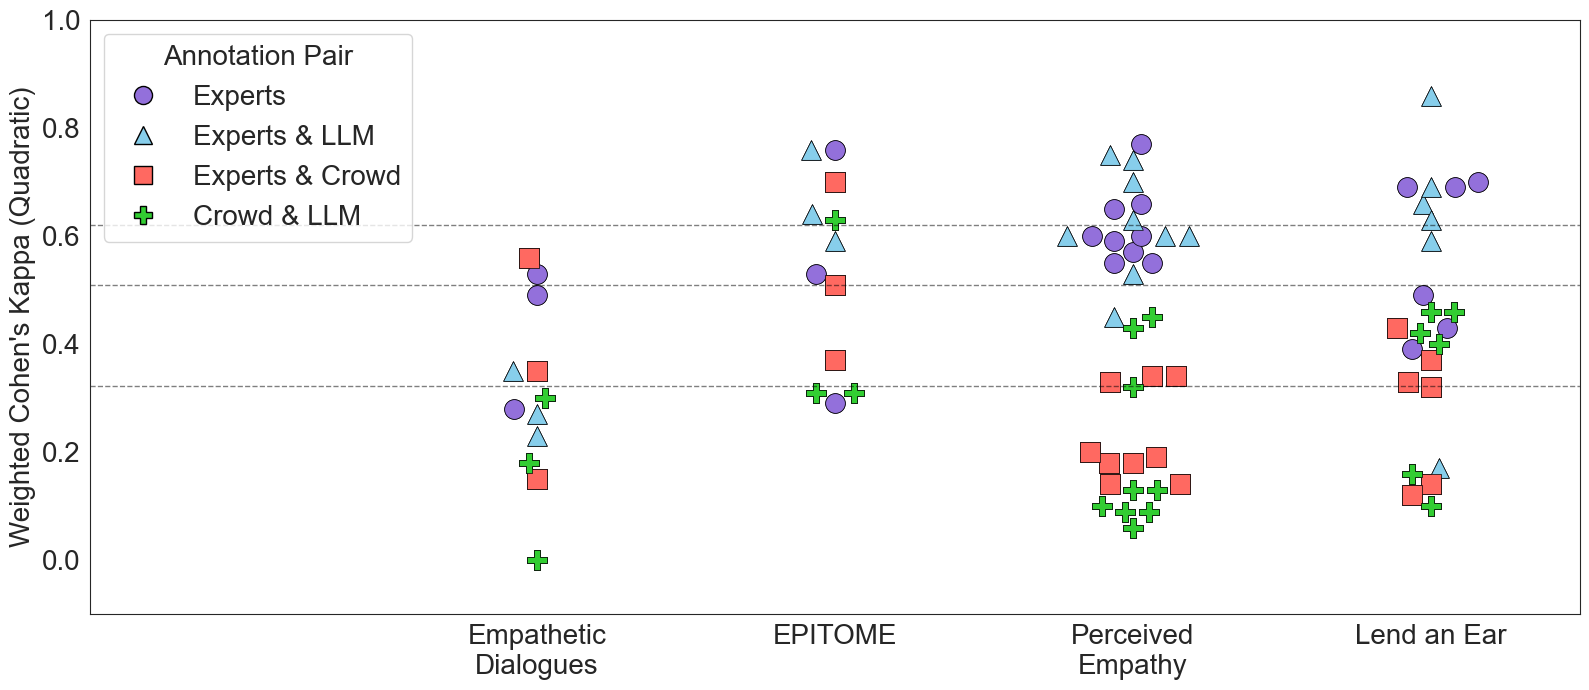

In [8]:
kappa = pd.read_csv("annotations/all_annotator_pairs_spearman_kappa.csv")

percentiles = np.percentile(kappa["Weighted Cohen's Kappa"].values.astype(float), [25, 50, 75])
print("Weighted Cohen's Kappa percentiles (25th, 50th, 75th):", percentiles)
sns.set_style("white")

# First identify expert-to-expert comparisons
expert_pairs = ["('expert1', 'expert2')", "('expert2', 'expert3')", "('expert3', 'expert1')"]

# Create a new dataframe to hold the median expert values
expert_medians = kappa[kappa["Annotator Pair"].isin(expert_pairs)].copy()
expert_medians["Weighted Cohen's Kappa"] = expert_medians["Weighted Cohen's Kappa"].astype(float)

# Calculate median per dataset and dimension
expert_medians = expert_medians.groupby(["Dataset", "Dimension"]).agg({
    "Weighted Cohen's Kappa": "median"
}).reset_index()

expert_medians["Annotator Pair"] = "Experts"

other_comparisons = kappa[
    ~kappa["Annotator Pair"].isin(expert_pairs) ][
    ["Dataset", "Dimension", "Annotator Pair", "Weighted Cohen's Kappa"]
]

label_mapping = {
    "('experts', 'crowd')": "Experts & Crowd",
    "('experts', 'llm')": "Experts & LLM",
    "('llm', 'crowd')": "Crowd & LLM",
}

# Clean labels
other_comparisons["Annotator Pair"] = other_comparisons["Annotator Pair"].replace(label_mapping)
other_comparisons["Weighted Cohen's Kappa"] = other_comparisons["Weighted Cohen's Kappa"].astype(float)

# Combine the expert medians with other comparisons
plot_data = pd.concat([expert_medians, other_comparisons])

colors = {
    "Experts": "#9370DB",         # Purple
    "Experts & Crowd": "#FF6961", # Red
    "Experts & LLM": "#87CEEB",   # Light Blue
    "Crowd & LLM": "#32CD32"      # Green
}

marker_mapping = {"Experts": "o", "Experts & LLM": "^", "Experts & Crowd": "s", "Crowd & LLM": "P"}
hue_order = ["Experts", "Experts & Crowd", "Experts & LLM", "Crowd & LLM"]
dataset_order = ["Empathetic Dialogues", "EPITOME", "Perceived Empathy", "Lend an Ear"]

plt.figure(figsize=(10, 7))
ax = sns.swarmplot(
    data=plot_data,
    x="Dataset",
    y="Weighted Cohen's Kappa",
    hue="Annotator Pair",
    hue_order=hue_order,
    order=dataset_order,
    palette=colors,
    size=13
)

# Get the positions from the swarmplot
points_by_hue = {hue: [] for hue in hue_order}

# For each dataset's collection
for dataset_idx, collection in enumerate(ax.collections):
    positions = collection.get_offsets().data
    points_per_hue = len(positions) // len(hue_order)
    
    for hue_idx, hue in enumerate(hue_order):
        start_idx = hue_idx * points_per_hue
        end_idx = start_idx + points_per_hue
        hue_positions = positions[start_idx:end_idx]
        points_by_hue[hue].append(hue_positions)

plt.close()

# Create final plot
fig, ax = plt.subplots(figsize=(16, 7))

for hue in hue_order:
    # add some jitter to the points
    all_positions = np.vstack(points_by_hue[hue])
    ax.scatter(
        all_positions[:, 0],
        all_positions[:, 1],
        marker=marker_mapping[hue],
        c=colors[hue],
        s=200,
        edgecolor='black',
        linewidth=0.5,
        label=hue
    )

plt.axhline(y=percentiles[0], color='black', linestyle='--', linewidth=1, alpha=0.5)
plt.axhline(y=percentiles[1], color='black', linestyle='--', linewidth=1, alpha=0.5)
plt.axhline(y=percentiles[2], color='black', linestyle='--', linewidth=1, alpha=0.5)


# Customize plot
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(
    ["Empathetic\nDialogues", "EPITOME", "Perceived\nEmpathy", "Lend an Ear"],
    fontsize=20
)
ax.set_yticklabels(
    ["-0.1", "0.0", "0.2", "0.4",  "0.6",  "0.8", "1.0"],
    fontsize=20
)
plt.xlabel("")
plt.ylabel("Weighted Cohen's Kappa (Quadratic)", fontsize=20)

legend_order = ["Experts", "Experts & LLM", "Experts & Crowd", "Crowd & LLM"]
for hue in legend_order:
    all_positions = np.vstack(points_by_hue[hue])
    ax.scatter(
        all_positions[:, 0],
        all_positions[:, 1],
        marker=marker_mapping[hue],
        c=colors[hue],
        s=200,
        edgecolor='black',
        linewidth=0.5,
        label=hue
    )
# Handle legend to avoid duplicates
legend_handles = [
    mlines.Line2D([], [], color=colors[hue], marker=marker_mapping[hue], linestyle='None',
                  markersize=13, label=hue, markerfacecolor=colors[hue], markeredgecolor='black')
    for hue in legend_order
]

ax.legend(
    handles=legend_handles,
    title="Annotation Pair",
    loc="upper left",
    frameon=True,
    fontsize=20,
    title_fontsize=20
)
plt.xlim(-1.5, 3.5)
plt.ylim(-0.1, 1)
plt.tight_layout()

plt.savefig("figs/MainFigure2.eps", dpi=300, bbox_inches="tight")
plt.show()

/var/folders/2d/fp_xlbjs1pndxz4df7hd6f500000gp/T/ipykernel_15826/587963614.py:192: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  ax.legend(handles=legend_handles, loc='upper left', fontsize=20)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Applying dimension and pair mappings...
Dimensions with Expert agreement below 0.55: [3, 4, 5, 6, 8, 11, 12, 15, 16, 19]


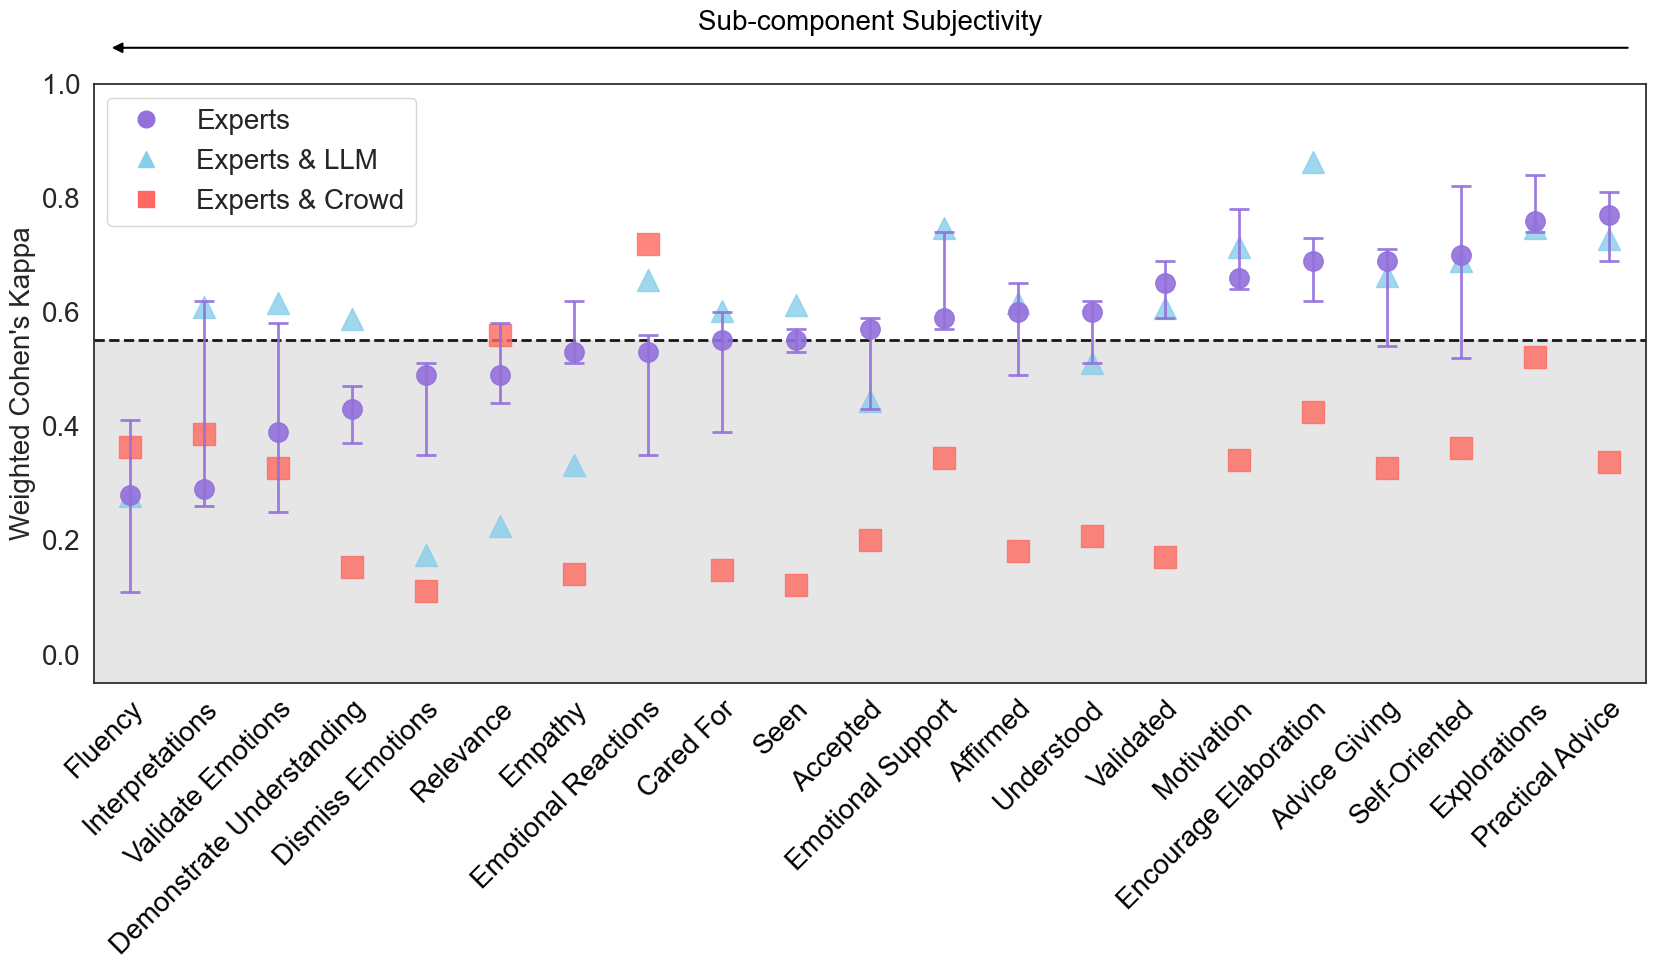

In [9]:
df = pd.read_csv("annotations/table_kappa.csv")

SOLID_GRAY = '#E6E6E6'  

if any(dim.islower() for dim in df['Dimension'].unique()):
    print("Applying dimension and pair mappings...")
    dimension_map = {
        'relevance': 'Relevance', 'fluency': 'Fluency', 'level_interpretations': 'Interpretations',
        'level_emotional_reactions': 'Emotional Reactions',
        'm_accepted': 'Accepted', 'validating_emotions': 'Validate Emotions',
        'dismissing_emotions': 'Dismiss Emotions', 'm_affirmed': 'Affirmed',
        'm_seen': 'Seen', 'm_caredfor': 'Cared For',
        'demonstrating_understanding': 'Demonstrate Understanding', 'm_validated': 'Validated',
        'm_understood': 'Understood', 'empathy': 'Empathy', 'm_emotional': 'Emotional Support',
        'encouraging_elaboration': 'Encourage Elaboration', 'm_motivation': 'Motivation',
        'm_practical': 'Practical Advice', 'advice_giving': 'Advice Giving',
        'level_explorations': 'Explorations', 'self_oriented': 'Self-Oriented'
    }

    df['Dimension'] = df['Dimension'].replace(dimension_map)

    pair_map = {
        "('expert1', 'expert2')": "Expert 1 & Expert 2",
        "('expert2', 'expert3')": "Expert 2 & Expert 3",
        "('expert3', 'expert1')": "Expert 3 & Expert 1",
        "('experts', 'llm')": "Experts & LLM",
        "('experts', 'crowd')": "Experts & Crowd",
        "('llm', 'crowd')": "LLM & Crowd"
    }
    df['Annotator Pair'] = df['Annotator Pair'].replace(pair_map)
else:
    print("Skipping mappings, dimension names seem appropriately formatted.")

pairs_to_plot = ["Experts & LLM", "Experts & Crowd"]
expert_pairs = ["Expert 1 & Expert 2", "Expert 2 & Expert 3", "Expert 3 & Expert 1"]
median_kappa = df[(df['Annotator Pair'] == "Expert 1 & Expert 2") | (df['Annotator Pair'] == "Expert 2 & Expert 3") | (df['Annotator Pair'] == "Expert 3 & Expert 1")]["Weighted Cohen's Kappa"].mean()

experts_kappa = df[df['Annotator Pair'].isin(expert_pairs)].groupby('Dimension')['Weighted Cohen\'s Kappa'].median().reset_index()
max_experts_kappa = df[df['Annotator Pair'].isin(expert_pairs)].groupby('Dimension')['Weighted Cohen\'s Kappa'].max().reset_index()
marker_map = {"Experts": "o", "Experts & LLM": "^", "Experts & Crowd": "s"}
color_map = {
    "Experts & Crowd": "#FF6961",      # Red
    "Experts & LLM": "#87CEEB",        # Light Blue
    "Experts": "#9370DB"               # Purple for expert median
}
correlation_threshold = 0.55  
gray_color = '#D3D3D3'  # Light gray

rank_calc_df = experts_kappa.sort_values('Weighted Cohen\'s Kappa', ascending=False)
rank_calc_df['rank'] = rank_calc_df.index + 1

sns.set_theme(style="white")
fig, ax = plt.subplots(figsize=(19, 10))


rank_calc_df['rank'] = rank_calc_df['Weighted Cohen\'s Kappa'].rank(method='first', ascending=True).astype(int)
rank_calc_df['Weighted Cohen\'s Kappa'] = rank_calc_df['Weighted Cohen\'s Kappa'].replace(-np.inf, np.nan)

rank_calc_df = rank_calc_df.sort_values('rank')

df = df.merge(rank_calc_df[['Dimension', 'rank']], on='Dimension', how='left')

df = df.sort_values('rank', ascending=True)

x_order = rank_calc_df['Dimension'].unique()  
x_values_map = {dim: i for i, dim in enumerate(x_order)}  
num_dimensions = len(x_order)

expert_data = df[df['Annotator Pair'].isin(expert_pairs)].copy()

expert_data['Weighted Cohen\'s Kappa'] = pd.to_numeric(expert_data['Weighted Cohen\'s Kappa'], errors='coerce')

expert_stats = expert_data.groupby('Dimension')['Weighted Cohen\'s Kappa'].agg(['median', 'min', 'max']).reset_index()


expert_stats['x_pos'] = expert_stats['Dimension'].map(x_values_map)

experts_kappa['Weighted Cohen\'s Kappa'] = pd.to_numeric(experts_kappa['Weighted Cohen\'s Kappa'], errors='coerce')
valid_expert_kappa = experts_kappa.dropna()
low_expert_agreement_dims = valid_expert_kappa[valid_expert_kappa['Weighted Cohen\'s Kappa'] <= correlation_threshold].index.tolist()
print(f"Dimensions with Expert agreement below {correlation_threshold}: {low_expert_agreement_dims}")

plot_df = df[df['Annotator Pair'].isin(pairs_to_plot)].copy()

all_y_values = df['Weighted Cohen\'s Kappa'].dropna()
if not all_y_values.empty:
    data_ymin = all_y_values.min(); data_ymax = all_y_values.max()
    plot_ymin = min(data_ymin, 0) - 0.05
    plot_ymax = max(data_ymax, correlation_threshold) + 0.05
else:
    plot_ymin, plot_ymax = -0.1, 1.25

ax.axhspan(plot_ymin, correlation_threshold, facecolor=SOLID_GRAY, edgecolor='none', zorder=0) # Below threshold

legend_handles = []

fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Plot expert median with error bars (min/max range)
if not expert_stats.empty:
    err_low = np.maximum(expert_stats['median'] - expert_stats['min'], 0.02)  # Minimum 0.02 size
    err_high = np.maximum(expert_stats['max'] - expert_stats['median'], 0.02)  # Minimum 0.02 size
    
    ax.errorbar(
        x=expert_stats['x_pos'],
        y=expert_stats['median'],
        yerr=[err_low, err_high],
        fmt='o',
        color="#9370DB",  # Purple
        markersize=14,
        capsize=7,
        capthick=2,
        elinewidth=2,
        alpha=.9,  
        zorder=10   
    )
    
    # Add expert median to legend
    legend_handles.append(mlines.Line2D([], [], color="#9370DB",
                                     marker='o', linestyle='None',
                                     markersize=12, label='Experts'))
else:
    print("No expert statistics available to plot")

# Plot other annotator pairs
for pair in pairs_to_plot:
    pair_data = plot_df[plot_df['Annotator Pair'] == pair].copy()
    if pair_data.empty: 
        continue

    # Map dimension to X position
    pair_data['x_pos'] = pair_data['Dimension'].map(x_values_map)
    current_marker = marker_map.get(pair, 'x')
    current_color = color_map.get(pair, 'lightgrey')
    
    # Add vertical jitter to the points
    pair_data['y_jitter'] = pair_data['Weighted Cohen\'s Kappa'] + np.random.uniform(-0.02, 0.02, len(pair_data))
    
    ax.scatter(
        x=pair_data['x_pos'],               
        y=pair_data['y_jitter'],
        marker=current_marker,
        color=current_color,
        s=250,
        alpha=.8,
        zorder=2
    )

    legend_handles.append(mlines.Line2D([], [], color=current_color,
                                       marker=current_marker, linestyle='None',
                                       markersize=12, label=pair))

# --- Add Horizontal Threshold Line ---
threshold_line = ax.axhline(y=correlation_threshold, color='black', linestyle='--',
                           linewidth=2, alpha=0.9, zorder=1.5)
legend_handles.append(threshold_line)

ax.set_xticks(np.arange(len(x_order)))
ax.set_xticklabels(x_order,
                   rotation=45,
                   ha='right',
                   rotation_mode='anchor',
                   fontsize=18)
ax.set_xlim(-0.5, num_dimensions - 0.5)

ax.set_ylabel("Weighted Cohen's Kappa", fontsize=20)
ax.set_xlabel("", fontsize=20)

# Set Y limits (kappa axis)
ax.set_ylim(plot_ymin, plot_ymax)

ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20, colors='black')

arrow_y = 1.06
arrow_x_left = 0.01
arrow_x_right = 0.99

ax.annotate('',
            xy=(arrow_x_right, arrow_y), xytext=(arrow_x_left, arrow_y),
            arrowprops=dict(arrowstyle='<|-', lw=1.5, color='black', mutation_scale=15),
            xycoords='axes fraction', textcoords='axes fraction', zorder=5)

ax.text(0.5, arrow_y + 0.02, 'Sub-component Subjectivity', fontsize=20,
        ha='center', va='bottom', color='black', transform=ax.transAxes)

ax.set_yticks(np.arange(0, 1.1, 0.2))
ax.set_yticklabels([f'{tick:.1f}' for tick in np.arange(0, 1.1, 0.2)])

# Add legend
ax.legend(handles=legend_handles, loc='upper left', fontsize=20)

plt.tight_layout(rect=[0, 0, 0.88, 1])  
plt.savefig('figs/MainFigure1.eps', format="eps", dpi=600)
plt.show()

In [10]:
table_kappa = pd.read_csv("annotations/table_kappa.csv") 
table_kappa

print('Mean, median, range, IQR, and standard deviation of Weighted Cohen\'s Kappa across all annotator pairs:')
print(table_kappa['Weighted Cohen\'s Kappa'].describe())

print('Summary of Weighted Cohen\'s Kappa for Expert 1 and Expert 2:')
print(table_kappa[table_kappa['Annotator Pair'] == "('expert1', 'expert2')"].describe())

print('Summary of Weighted Cohen\'s Kappa for Experts and LLM:')
print(table_kappa[table_kappa['Annotator Pair'] == "('experts', 'llm')"].describe())

print('Summary of Weighted Cohen\'s Kappa for Experts and Crowd:')
print(table_kappa[table_kappa['Annotator Pair'] == "('experts', 'crowd')"].describe())

print('Summary of Weighted Cohen\'s Kappa for LLM and Crowd:')
print(table_kappa[table_kappa['Annotator Pair'] == "('llm', 'crowd')"].describe())

print('Summary of Weighted Cohen\'s Kappa for Dataset RPG:')
print(table_kappa[table_kappa['Dataset'] == "RPG"].describe())

print('Summary of Weighted Cohen\'s Kappa for Dataset Perceived Empathy:')
print(table_kappa[table_kappa['Dataset'] == "Perceived Empathy"].describe())

print('Summary of Weighted Cohen\'s Kappa for Dataset Empathetic Dialogues:')
print(table_kappa[table_kappa['Dataset'] == "Empathetic Dialogues"].describe())

print('Summary of Weighted Cohen\'s Kappa for Dataset EPITOME:')
print(table_kappa[table_kappa['Dataset'] == "EPITOME"].describe())





Mean, median, range, IQR, and standard deviation of Weighted Cohen's Kappa across all annotator pairs:
count    126.000000
mean       0.469603
std        0.207439
min        0.000000
25%        0.322500
50%        0.510000
75%        0.620000
max        0.860000
Name: Weighted Cohen's Kappa, dtype: float64
Summary of Weighted Cohen's Kappa for Expert 1 and Expert 2:
       Weighted Cohen's Kappa  Kappa P-value
count               21.000000      21.000000
mean                 0.536190       0.010143
std                  0.176195       0.032871
min                  0.250000       0.000000
25%                  0.430000       0.000000
50%                  0.550000       0.000000
75%                  0.690000       0.001000
max                  0.820000       0.149000
Summary of Weighted Cohen's Kappa for Experts and LLM:
       Weighted Cohen's Kappa  Kappa P-value
count               21.000000      21.000000
mean                 0.573333       0.011286
std                  0.182519       

/var/folders/2d/fp_xlbjs1pndxz4df7hd6f500000gp/T/ipykernel_15826/3389310542.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  experts_all[dims] = experts_all[dims].apply(
/var/folders/2d/fp_xlbjs1pndxz4df7hd6f500000gp/T/ipykernel_15826/3389310542.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  experts_all[dims] = experts_all[dims].apply(
/var/folders/2d/fp_xlbjs1pndxz4df7hd6f500000gp/T/ipykernel_15826/3389310542.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

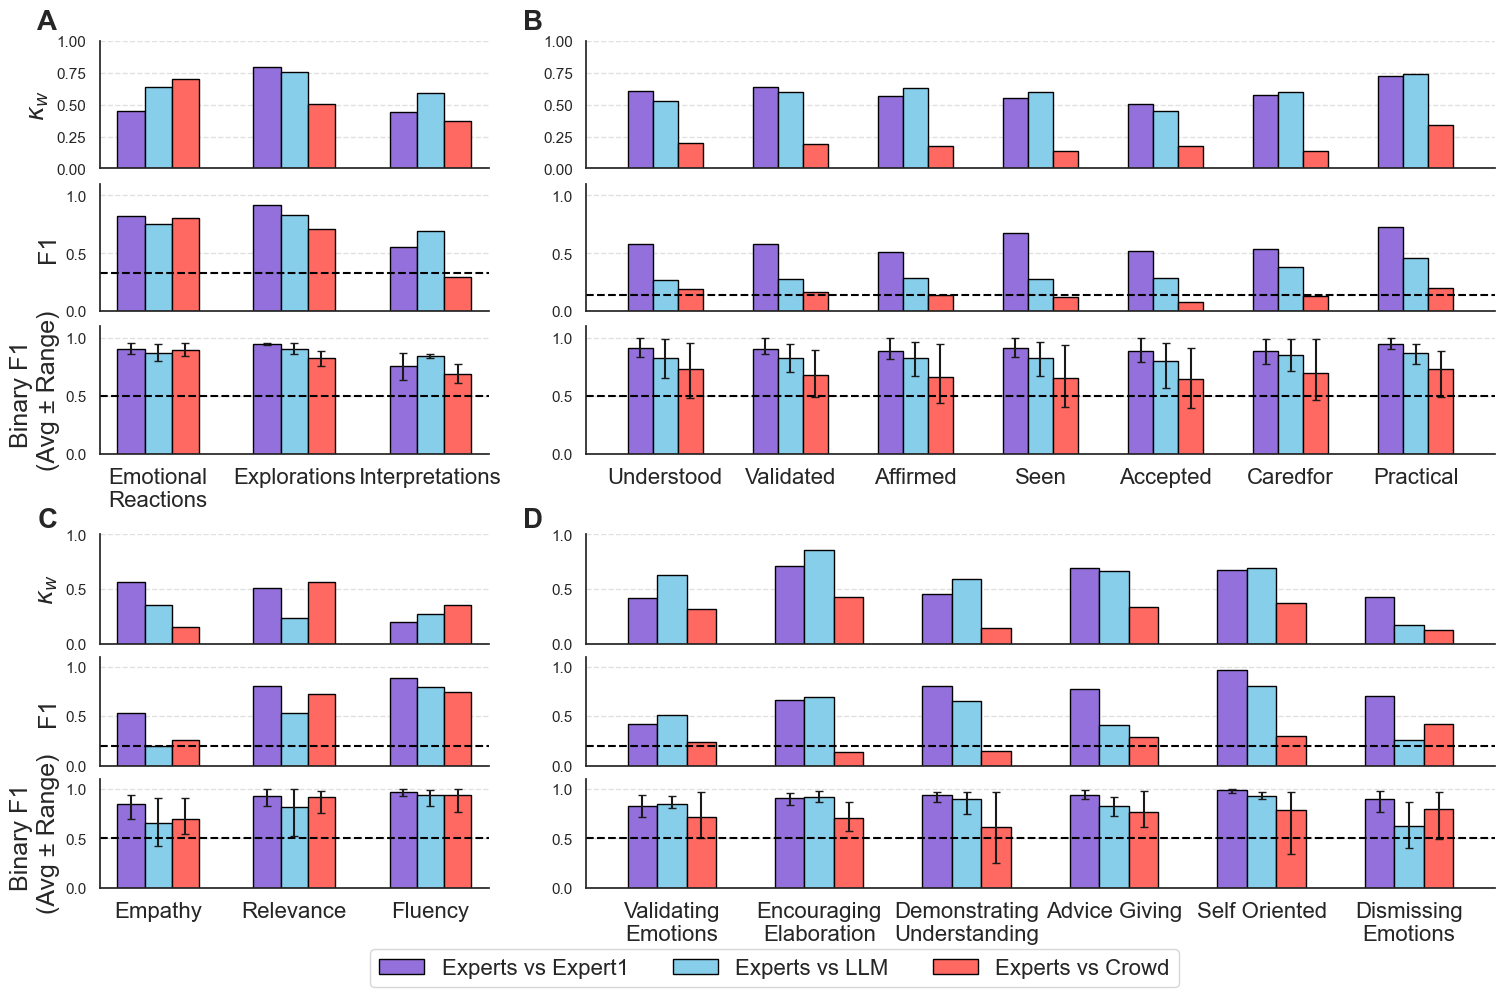

In [11]:
df = pd.read_csv("annotations/combined_annotations_across_methods_and_datasets.csv")
kappa_df = pd.read_csv("annotations/table_kappa.csv")


kappa_df['Dataset']       = kappa_df['Dataset'].str.strip().str.lower()
kappa_df['Dimension']     = kappa_df['Dimension'].str.strip()
kappa_df['Annotator Pair'] = kappa_df['Annotator Pair'].str.strip()

kappa_col = 'Weighted Cohen\'s Kappa'
expert_pairs = ["('expert1', 'expert2')",
                "('expert2', 'expert3')",
                "('expert1', 'expert3')"]

expert_medians = (
    kappa_df[kappa_df['Annotator Pair'].isin(expert_pairs)]
    .groupby(['Dataset', 'Dimension'])[kappa_col]
    .median()
    .reset_index()
    .rename(columns={kappa_col: 'Expert_Median_Kappa'})
)
expert_median_lookup = {
    (row['Dataset'], row['Dimension']): row['Expert_Median_Kappa']
    for _, row in expert_medians.iterrows()
}

kappa_lookup = {
    (row['Dataset'], row['Dimension'], row['Annotator Pair']): row[kappa_col]
    for _, row in kappa_df.iterrows()
}

datasets = {
    'epitome': {
        'dimensions' : ['level_emotional_reactions',
                        'level_explorations',
                        'level_interpretations'],
        'kappa_label': 'epitome',
        'id_column'  : 'epitome_conversation_id'
    },
     'perceived_empathy': {
        'dimensions' : ['m_understood', 'm_validated', 'm_affirmed',
                        'm_seen', 'm_accepted', 'm_caredfor', 'm_practical'],
        'kappa_label': 'perceived empathy',
        'id_column'  : 'perceived_conversation_id'
    },
    'empatheticdialogues': {
        'dimensions' : ['empathy',
                        'relevance',
                        'fluency',
                        ],
        'kappa_label': 'empathetic dialogues',
        'id_column'  : 'empathetic_conversation_id'
    },
     'lend_an_ear': {
        'dimensions' : ["validating_emotions",
            "encouraging_elaboration",
            "demonstrating_understanding",
            "advice_giving",
            "self_oriented",
            "dismissing_emotions",],
        'kappa_label': 'lend an ear',
        'id_column'  : 'lend_an_ear_conversation_id'
    }
}

theoretical_scales = {
    'epitome': {'min':0, 'max':2},
    'perceived_empathy': {'min':1, 'max':7},
    'empatheticdialogues': {'min':1, 'max':5},
    'lend_an_ear': {'min':1, 'max':5},
}


available_kappa_datasets = kappa_df['Dataset'].unique()
dataset_names = list(datasets.keys()) 

kappa_pair_map = {
    'llm'  : "('experts', 'llm')",
    'crowd': "('experts', 'crowd')"
}
kappa_scores = {}
for ds in dataset_names:
    dims       = datasets[ds]['dimensions']
    kappa_label = datasets[ds]['kappa_label'].lower()
    kappa_scores[ds] = {'scores': {}}
    # median‑experts
    kappa_scores[ds]['scores']['experts'] = {
        d: {'Kappa': expert_median_lookup.get((kappa_label, d), 0.0)}
        for d in dims
    }
    # llm & crowd
    for m in ['llm', 'crowd']:
        pair = kappa_pair_map[m]
        kappa_scores[ds]['scores'][m] = {}
        for d in dims:
            κ = kappa_lookup.get((kappa_label, d, pair), 0.0)
            # special case renaming for perceived_empathy dims
            if κ == 0.0 and ds == 'perceived_empathy':
                d_alt = d.replace('m_', '').title()
                κ = kappa_lookup.get((kappa_label, d_alt, pair), 0.0)
            kappa_scores[ds]['scores'][m][d] = {'Kappa': float(κ)}

def get_aligned_ratings(df_dataset, id_col, dim, method):
    baseline = df_dataset[df_dataset['annotation_method'] == 'experts_median']
    other    = df_dataset[df_dataset['annotation_method'] == method]
    if dim not in baseline.columns or dim not in other.columns:
        return pd.Series([], dtype=float), pd.Series([], dtype=float)
    merged = pd.merge(
        baseline[[id_col, dim]].dropna(subset=[dim]),
        other   [[id_col, dim]].dropna(subset=[dim]),
        on=id_col, suffixes=('_exp', f'_{method}')
    )
    if merged.empty:
        return pd.Series([], dtype=float), pd.Series([], dtype=float)
    a = pd.to_numeric(merged[f'{dim}_exp'   ], errors='coerce').round(0)
    b = pd.to_numeric(merged[f'{dim}_{method}'], errors='coerce').round(0)
    mask = a.notna() & b.notna()
    return a[mask], b[mask]

def calculate_f1_scores(df_dataset, dims, method, id_col):
    out = {}
    for d in dims:
        e, m = get_aligned_ratings(df_dataset, id_col, d, method)
        out[d] = {'F1 Score': f1_score(e, m, average='weighted', zero_division=0)
                  if not e.empty else 0.0}
    return out

def calculate_binary_f1_stats(df_dataset, dims, method, id_col, lo, hi):
    stats = {}
    thr_range = range(int(lo+1), int(hi+1)) or [int(lo+1)]
    for d in dims:
        e, m = get_aligned_ratings(df_dataset, id_col, d, method)
        if e.empty:
            stats[d] = {'Avg':0,'Min':0,'Max':0,'Scores_Per_Threshold':[]}
            continue
        vals, detailed = [], []
        for t in thr_range:
            f = f1_score((e>=t).astype(int), (m>=t).astype(int),
                         average='weighted', zero_division=0)
            vals.append(f); detailed.append((t,f))
        stats[d] = {'Avg': np.mean(vals), 'Min': np.min(vals),
                    'Max': np.max(vals), 'Scores_Per_Threshold': detailed}
    return stats

f1_scores, binary_f1_stats, num_classes_per_dataset = {}, {}, {}
comparison_methods_f1 = ['expert1', 'llm', 'crowd']
dataset_col_in_df = 'dataset'

for ds in dataset_names:
    dims  = datasets[ds]['dimensions']
    idcol = datasets[ds]['id_column']
    f1_scores[ds]       = {'scores': {}}
    binary_f1_stats[ds] = {'scores': {}}
    num_classes_per_dataset[ds] = 0

    df_ds = (df[df[dataset_col_in_df] == ds] if dataset_col_in_df in df.columns
             else df.copy())
    if df_ds.empty:
        continue

    experts_all = df_ds[df_ds['annotation_method']
                        .isin(['expert1', 'expert2', 'expert3'])]
    if not experts_all.empty:
        experts_all[dims] = experts_all[dims].apply(
            pd.to_numeric, errors='coerce'
        )
        med = (experts_all.groupby(idcol)[dims]
            .median()
            .reset_index()
            .assign(annotation_method='experts_median'))
        if dataset_col_in_df in df.columns:
            med[dataset_col_in_df] = ds
        df_ds = pd.concat([df_ds, med], ignore_index=True)

    ex1 = df_ds[df_ds['annotation_method'] == 'expert1']
    if not ex1.empty:
        flat    = ex1[dims].to_numpy().ravel()
        numeric = pd.Series(pd.to_numeric(flat, errors='coerce')) \
                    .dropna().round(0)
        uniq = numeric.nunique()
        if uniq > 1:
            num_classes_per_dataset[ds] = uniq

    scale = theoretical_scales.get(ds, {'min':None,'max':None})

    for m in comparison_methods_f1:
        f1_scores[ds]['scores'][m] = calculate_f1_scores(
            df_ds, dims, m, idcol)
        if scale['min'] is not None:
            binary_f1_stats[ds]['scores'][m] = calculate_binary_f1_stats(
                df_ds, dims, m, idcol, scale['min'], scale['max'])
        else:
            binary_f1_stats[ds]['scores'][m] = {
                d:{'Avg':0,'Min':0,'Max':0,'Scores_Per_Threshold':[]} for d in dims
            }



def plot_single_dataset_metrics(ds, axes, show_ylabel=True):
    ax_k, ax_f1o, ax_f1b = axes
    dims   = datasets[ds]['dimensions']
    n_dims = len(dims)
    x      = np.arange(n_dims)
    bar_w  = 0.20
    offsets = np.linspace(-bar_w, bar_w, 3)

    cols = {'experts':'#9370DB', 'expert1':'#9370DB',
            'llm':'#87CEEB', 'crowd':'#FF6961'}
    k_keys  = ['experts','llm','crowd']
    f1_keys = ['expert1','llm','crowd']

    # Plot kappa scores
    for i,k in enumerate(k_keys):
        ys = [kappa_scores[ds]['scores'][k][d]['Kappa'] for d in dims]
        ax_k.bar(x+offsets[i], ys, bar_w, color=cols[k], edgecolor='black')
    if show_ylabel:
        ax_k.set_ylabel(r'$\kappa_w$',fontsize=18)
    ax_k.set_ylim(0,1)
    ax_k.set_xticks([])
    ax_k.grid(axis='y',ls='--',alpha=.6)
    ax_k.spines[['top','right']].set_visible(False)
    ax_k.set_title(ds.replace('_', ' ').title(), fontsize=16, pad=20)


    # Plot F1 scores
    for i,k in enumerate(f1_keys):
        ys = [f1_scores[ds]['scores'][k][d]['F1 Score'] for d in dims]
        ax_f1o.bar(x+offsets[i], ys, bar_w, color=cols[k], edgecolor='black')
    n_cls = num_classes_per_dataset[ds]
    thresh = 1/n_cls if n_cls>1 else 0
    ax_f1o.axhline(thresh,ls='--',c='black')
    if show_ylabel:
        ax_f1o.set_ylabel('F1',fontsize=18)
    ax_f1o.set_ylim(0,1.1)
    ax_f1o.set_xticks([])
    ax_f1o.grid(axis='y',ls='--',alpha=.6)
    ax_f1o.spines[['top','right']].set_visible(False)

    # Plot binary F1 stats
    for i,k in enumerate(f1_keys):
        avg = [binary_f1_stats[ds]['scores'][k][d]['Avg'] for d in dims]
        mn  = [binary_f1_stats[ds]['scores'][k][d]['Min'] for d in dims]
        mx  = [binary_f1_stats[ds]['scores'][k][d]['Max'] for d in dims]
        err = np.vstack([np.maximum(0,np.array(avg)-mn),
                         np.maximum(0,mx-np.array(avg))])
        ax_f1b.bar(x+offsets[i], avg, bar_w, yerr=err, capsize=3,
                   color=cols[k], edgecolor='black')
    ax_f1b.axhline(.5,ls='--',c='black')
    if show_ylabel:
        ax_f1b.set_ylabel('Binary F1 \n(Avg ± Range)',fontsize=18)
    ax_f1b.set_ylim(0,1.1)
    labels = [textwrap.fill(d.replace('level_','').replace('m_','')
                            .replace('_',' ').title(),15) for d in dims]
    ax_f1b.set_xticks(x)
    ax_f1b.set_xticklabels(labels,fontsize=16,rotation=0)
    ax_f1b.grid(axis='y',ls='--',alpha=.6)
    ax_f1b.spines[['top','right']].set_visible(False)


plot_order = ['epitome', 'perceived_empathy', 'empatheticdialogues', 'lend_an_ear']
plot_positions = [(0, 0), (0, 1), (1, 0), (1, 1)]
subplot_labels = ['A', 'B', 'C', 'D']

width_ratios = [
    len(datasets['epitome']['dimensions']),           # Column 0
    len(datasets['perceived_empathy']['dimensions'])  # Column 1
]
height_ratios = [
    max(len(datasets['epitome']['dimensions']), len(datasets['perceived_empathy']['dimensions'])),        # Row 0
    max(len(datasets['empatheticdialogues']['dimensions']), len(datasets['lend_an_ear']['dimensions']))          # Row 1
]

fig = plt.figure(figsize=(18, 11))
gs = fig.add_gridspec(2, 2, width_ratios=width_ratios, height_ratios=height_ratios, 
                      wspace=0.15, hspace=0.21)

for i, ds in enumerate(plot_order):
    row, col = plot_positions[i]
    subplot_label = subplot_labels[i]

    sub_gs = gs[row, col].subgridspec(3, 1, hspace=0.12)
    axes = [fig.add_subplot(sub_gs[j, 0]) for j in range(3)]

    plot_single_dataset_metrics(ds, axes, show_ylabel=(col == 0))

    label_x_pos = -0.16 if col == 0 else -0.07
    axes[0].text(label_x_pos, 1.25, subplot_label, transform=axes[0].transAxes,
                  fontsize=20, fontweight='bold', va='top', ha='left')
    axes[0].set_title('')

labels = ['Experts vs Expert1','Experts vs LLM','Experts vs Crowd']
cols   = ['#9370DB','#87CEEB','#FF6961']
handles = [mpatches.Patch(fc=c,ec='black',label=l) for c,l in zip(cols,labels)]
fig.legend(handles=handles,loc='lower center',bbox_to_anchor=(0.5, 0.01),
           ncol=3,fontsize=16)


plt.tight_layout(rect=[0, 0.05, 1, 0.95])

plt.savefig('figs/MainFigure3.eps', bbox_inches='tight', dpi=300)

plt.show()

/var/folders/2d/fp_xlbjs1pndxz4df7hd6f500000gp/T/ipykernel_15826/800180819.py:161: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.98])
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


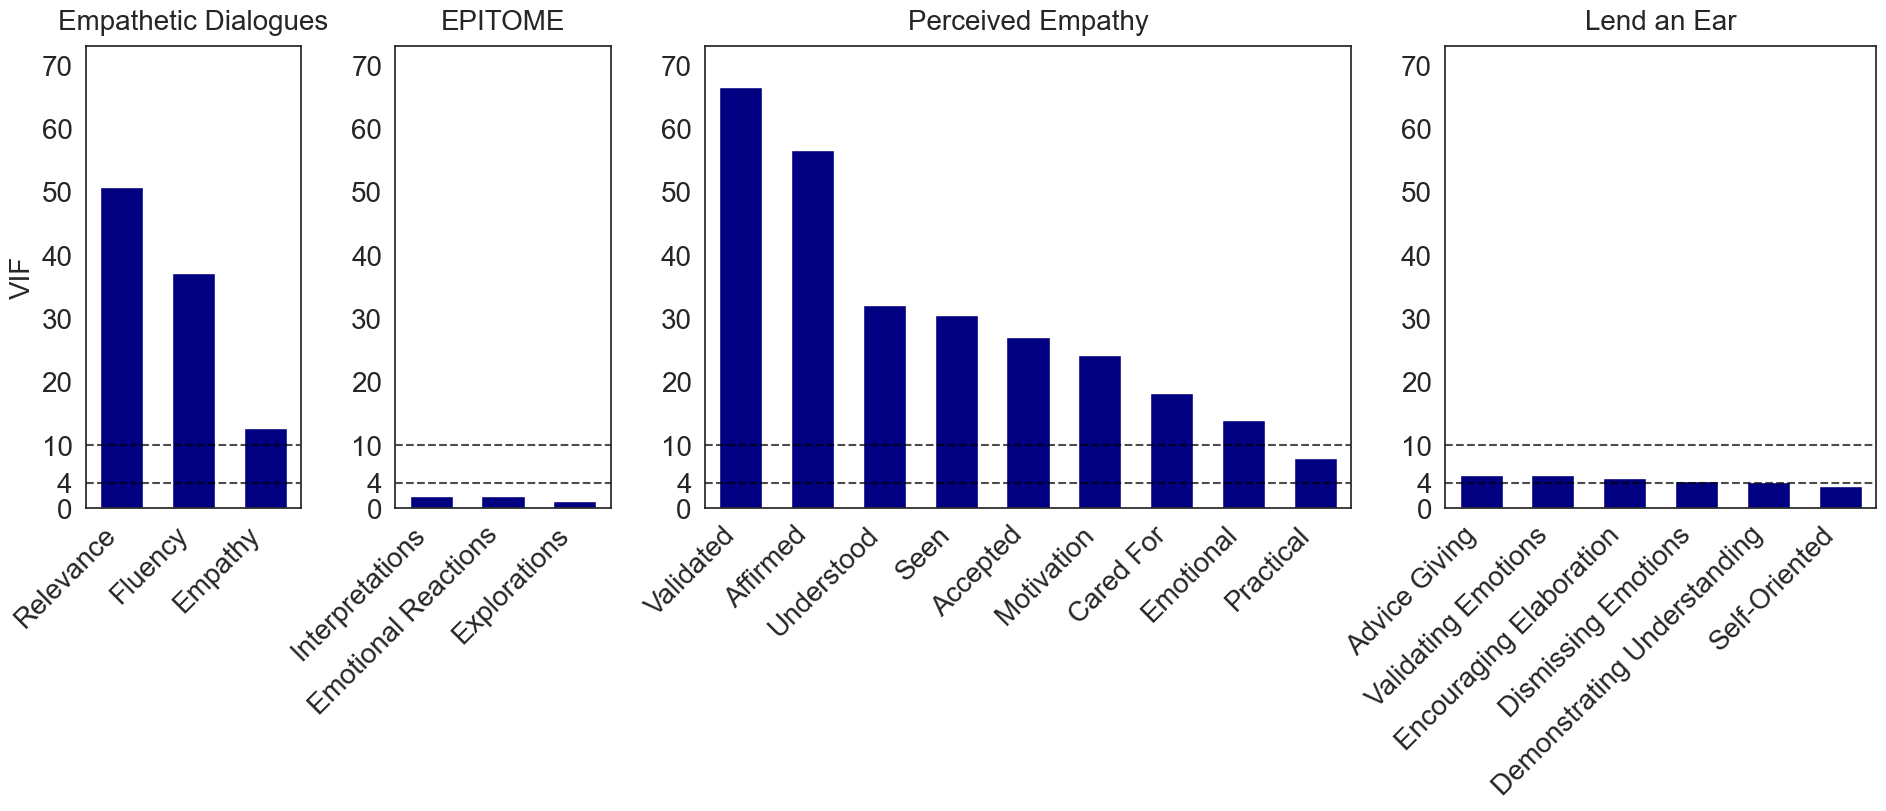

In [12]:
data = pd.read_csv("annotations/combined_annotations_across_methods_and_datasets.csv")

ordered_datasets = [
    "empatheticdialogues",  
    "epitome",              
    "perceived_empathy",    
    "lend_an_ear"                   
]

dataset_info = {
    "lend_an_ear": {
        "dimensions": [
            "validating_emotions",
            "encouraging_elaboration",
            "demonstrating_understanding",
            "advice_giving",
            "self_oriented",
            "dismissing_emotions",
        ],
        "display_names": [
            "Validating Emotions",
            "Encouraging Elaboration",
            "Demonstrating Understanding",
            "Advice Giving",
            "Self-Oriented",
            "Dismissing Emotions",
        ]
    },
    "perceived_empathy": {
        "dimensions": [
            "m_understood",
            "m_validated",
            "m_affirmed",
            "m_seen",
            "m_accepted",
            "m_caredfor",
            "m_emotional",
            "m_practical",
            "m_motivation",
        ],
        "display_names": [
            "Understood",
            "Validated",
            "Affirmed",
            "Seen",
            "Accepted",
            "Cared For",
            "Emotional",
            "Practical",
            "Motivation",
        ]
    },
    "empatheticdialogues": {
        "dimensions": [
            "empathy",
            "relevance",
            "fluency",
        ],
        "display_names": [
            "Empathy",
            "Relevance",
            "Fluency",
        ]
    },
    "epitome": {
        "dimensions": [
            "level_emotional_reactions",
            "level_explorations",
            "level_interpretations",
        ],
        "display_names": [
            "Emotional Reactions",
            "Explorations",
            "Interpretations",
        ]
    },
}

dataset_mapping = {
    'empatheticdialogues': 'Empathetic Dialogues',
    'epitome': 'EPITOME',
    'perceived_empathy': 'Perceived Empathy',
    'lend_an_ear': 'Lend an Ear'
}
sns.set_theme(style="whitegrid")

for col in data.columns:
    if col not in ['lend_an_ear_conversation_id', 'perceived_conversation_id', 'empathetic_conversation_id', 
                  'epitome_conversation_id', 'annotation_method', 'full_conversation', 'rp_id']:
        data[col] = pd.to_numeric(data[col], errors='coerce')

expert_data = data[data['annotation_method'].isin(['expert1', 'expert2', 'expert3'])]

def calculate_standard_vif(df, dimensions):
    df_clean = df[dimensions].dropna()
    
    if len(df_clean) <= len(dimensions):
        print(f"Warning: Not enough data points ({len(df_clean)}) for reliable VIF calculation with {len(dimensions)} dimensions")
        return pd.DataFrame({'Dimension': dimensions, 'VIF': [np.nan] * len(dimensions)})
    
    vif_data = pd.DataFrame()
    vif_data["Dimension"] = dimensions
    vif_data["VIF"] = [variance_inflation_factor(df_clean.values, i) for i in range(len(dimensions))]
    
    return vif_data

all_vifs = []
vif_results = {}
for dataset_name in ordered_datasets:
    dims = dataset_info[dataset_name]["dimensions"]
    available_dims = [dim for dim in dims if dim in expert_data.columns]
    if len(available_dims) > 1:
        dataset_df = expert_data[available_dims].copy()
        vif_data = calculate_standard_vif(dataset_df, available_dims)
        all_vifs.extend(vif_data["VIF"].dropna().tolist())
        vif_results[dataset_name] = vif_data

if all_vifs:
    global_ymax = np.ceil(max(all_vifs) / 5) * 5
else:
    global_ymax = 10
max_bars = max(len(dataset_info[ds]["dimensions"]) for ds in ordered_datasets)
n_bars_list = [len(dataset_info[ds]["dimensions"]) for ds in ordered_datasets]

sns.set_theme(style="white")
fig = plt.figure(figsize=(1.1 * sum(n_bars_list), 6))
gs = fig.add_gridspec(1, 4, width_ratios=n_bars_list, wspace=0.25)
bar_width = 0.6
bar_color = 'navy'

for idx, dataset_name in enumerate(ordered_datasets):
    ax = fig.add_subplot(gs[0, idx])
    vif_data = vif_results.get(dataset_name)
    if vif_data is not None:
        display_names = dataset_info[dataset_name]["display_names"]
        dims = dataset_info[dataset_name]["dimensions"]
        available_dims = [dim for dim in dims if dim in expert_data.columns]
        available_display_names = [display_names[dims.index(dim)] for dim in available_dims]
        vif_data["Dimension"] = [available_display_names[available_dims.index(dim)] for dim in vif_data["Dimension"]]
        vif_data = vif_data.sort_values("VIF", ascending=False)
        
        x = np.arange(len(vif_data))
        bars = ax.bar(x, vif_data["VIF"], width=bar_width, color=bar_color)
        ax.set_xticks(x)
        ax.set_xticklabels(vif_data["Dimension"], rotation=45, ha="right", fontsize=20)
        ax.set_yticks([0, 4, 10, 20, 30, 40, 50, 60, 70])
        ax.set_yticklabels([0, 4, 10, 20, 30, 40, 50, 60, 70], fontsize=20)
        ax.set_ylim(0, global_ymax+3)
        ax.set_xlim(-0.5, len(vif_data)-0.5)
        ax.axhline(y=4, color='black', linestyle='--', alpha=0.7)
        ax.axhline(y=10, color='black', linestyle='--', alpha=0.7)
        ax.set_title(dataset_mapping.get(dataset_name, dataset_name), fontsize=20, pad=12)
        if idx == 0:
            ax.set_ylabel("VIF", fontsize=20)
    else:
        ax.set_xticks([])
        ax.set_title(dataset_mapping.get(dataset_name, dataset_name), fontsize=18)
        if idx == 0:
            ax.set_ylabel("VIF", fontsize=20)
            
plt.tight_layout(rect=[0, 0.03, 1, 0.98])

plt.savefig("figs/ExtendedDataFigure4.eps", dpi=300, bbox_inches="tight")
plt.show()


Calculating bootstrapped Krippendorff's alpha for Empathetic Dialogues...
  empathy: alpha=0.529
  fluency: alpha=0.290
  relevance: alpha=0.487
  Dataset mean alpha: 0.435, 95% CI: [0.234, 0.532]

Calculating bootstrapped Krippendorff's alpha for EPITOME...
  level_emotional_reactions: alpha=0.466
  level_explorations: alpha=0.780
  level_interpretations: alpha=0.316
  Dataset mean alpha: 0.520, 95% CI: [0.427, 0.596]

Calculating bootstrapped Krippendorff's alpha for Perceived Empathy...
  m_understood: alpha=0.570
  m_validated: alpha=0.643
  m_affirmed: alpha=0.577
  m_seen: alpha=0.545
  m_accepted: alpha=0.521
  m_caredfor: alpha=0.485
  m_emotional: alpha=0.628
  m_practical: alpha=0.759
  m_motivation: alpha=0.696
  Dataset mean alpha: 0.603, 95% CI: [0.521, 0.669]

Calculating bootstrapped Krippendorff's alpha for Lend an Ear...
  validating_emotions: alpha=0.361
  encouraging_elaboration: alpha=0.677
  demonstrating_understanding: alpha=0.416
  self_oriented: alpha=0.672
  a

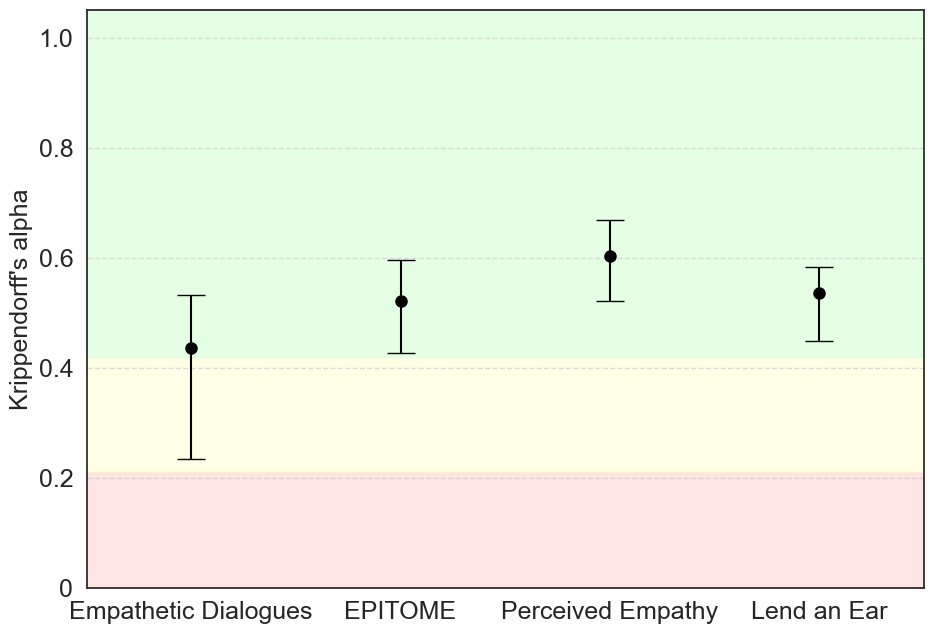

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


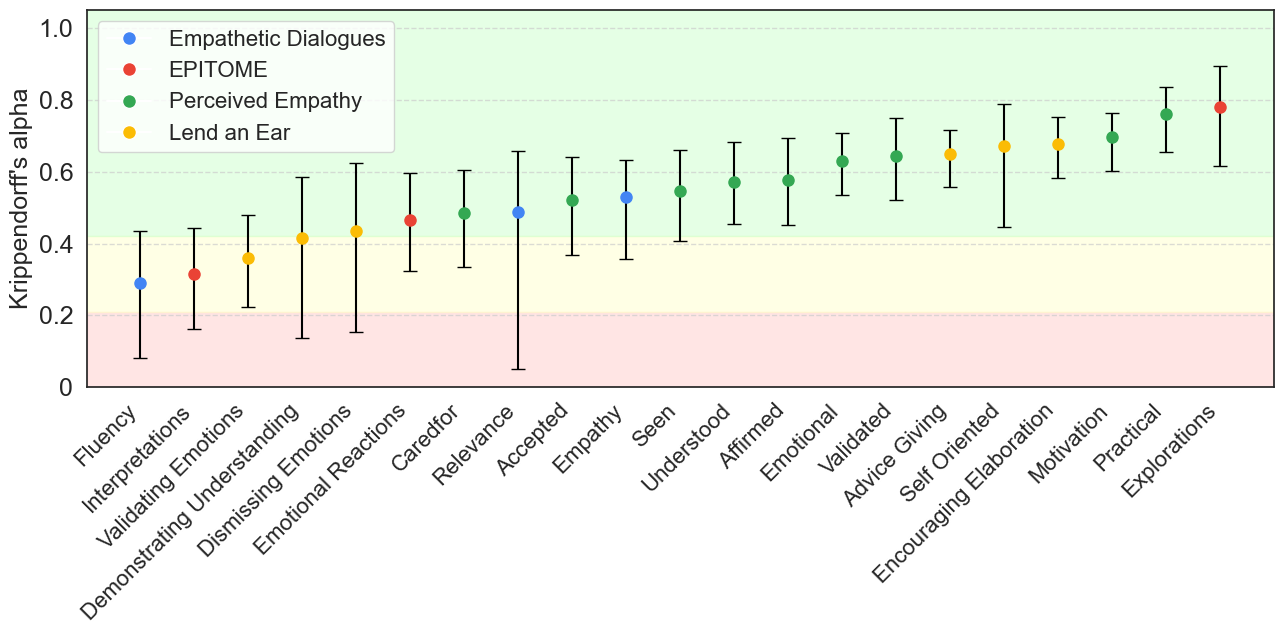

In [13]:
df = pd.read_csv("annotations/combined_annotations_across_methods_and_datasets.csv")

def calculate_krippendorfs_alpha_manual(df, dimension, dataset_id_column):
    """Manual implementation of Krippendorf's alpha for three expert annotators."""
    # Filter data for each expert
    expert1_data = df[df['annotation_method'] == 'expert1'][[dataset_id_column, dimension]].set_index(dataset_id_column)
    expert2_data = df[df['annotation_method'] == 'expert2'][[dataset_id_column, dimension]].set_index(dataset_id_column)
    expert3_data = df[df['annotation_method'] == 'expert3'][[dataset_id_column, dimension]].set_index(dataset_id_column)
    
    # Join the data
    combined_data = pd.concat([
        expert1_data.rename(columns={dimension: 'expert1'}),
        expert2_data.rename(columns={dimension: 'expert2'}),
        expert3_data.rename(columns={dimension: 'expert3'})
    ], axis=1)
    
    # Convert to numeric and handle missing values
    for col in ['expert1', 'expert2', 'expert3']:
        combined_data[col] = pd.to_numeric(combined_data[col], errors='coerce')
    
    combined_data = combined_data.dropna(how='all')
    sample_size = len(combined_data)
    
    if sample_size < 2:
        return np.nan, 0
    
    # Prepare data array
    data = combined_data[['expert1', 'expert2', 'expert3']].values.T
    
    # Calculate observed disagreement
    observed_disagreement = 0
    n_values = 0
    
    for item_idx in range(data.shape[1]):
        item_data = data[:, item_idx]
        valid_values = item_data[~np.isnan(item_data)]
        n_valid = len(valid_values)
        
        if n_valid < 2:
            continue
            
        for i in range(n_valid):
            for j in range(i+1, n_valid):
                observed_disagreement += (valid_values[i] - valid_values[j])**2
                n_values += 1
    
    if n_values == 0:
        return np.nan, sample_size
        
    observed_disagreement /= n_values
    
    # Calculate expected disagreement
    all_valid_values = data[~np.isnan(data)]
    if len(all_valid_values) < 2:
        return np.nan, sample_size
        
    expected_disagreement = 0
    n_pairs = len(all_valid_values) * (len(all_valid_values) - 1)
    
    if n_pairs == 0:
        return np.nan, sample_size
        
    for i in range(len(all_valid_values)):
        for j in range(len(all_valid_values)):
            if i != j:
                expected_disagreement += (all_valid_values[i] - all_valid_values[j])**2
    
    expected_disagreement /= n_pairs
    
    # Calculate alpha
    if expected_disagreement == 0:
        return 1.0, sample_size  # Perfect agreement
    
    alpha = 1 - (observed_disagreement / expected_disagreement)
    return alpha, sample_size

def bootstrap_all_alphas(df, dataset_info, n_bootstrap=1000, confidence=0.95):
    """
    Calculate both dataset-level and dimension-level bootstrapped confidence intervals 
    for Krippendorff's alpha in a single pass.
    
    Parameters:
    - df: DataFrame containing annotations
    - dataset_info: List of dictionaries with dataset information
    - n_bootstrap: Number of bootstrap samples
    - confidence: Confidence level for intervals
    
    Returns:
    - dataset_results: Dictionary with dataset-level results
    - dimension_results: List of dictionaries with dimension-level results
    """
    # Initialize results containers
    dataset_results = {}
    dimension_results = []
    
    # Process each dataset
    for dataset in dataset_info:
        dataset_name = dataset['display_name']
        dimensions = dataset['dimensions']
        dataset_id_column = dataset['id_column']
        print(f"\nCalculating bootstrapped Krippendorff's alpha for {dataset_name}...")
        
        all_ids = df[df['annotation_method'].isin(['expert1', 'expert2', 'expert3'])][dataset_id_column].unique()
        if len(all_ids) < 5:
            print(f"Warning: Only {len(all_ids)} unique IDs found - bootstrapping may be unreliable")
            continue
        
        # Calculate original alphas for each dimension
        orig_alphas = {}
        sample_sizes = []
        dimension_bootstrap_data = {}  # Store bootstrap data for each dimension
        
        for dimension in dimensions:
            try:
                # Calculate original alpha for this dimension
                alpha, n = calculate_krippendorfs_alpha_manual(df, dimension, dataset_id_column)
                orig_alphas[dimension] = alpha
                sample_sizes.append(n)
                
                # Only bootstrap if we have a valid alpha value
                if not np.isnan(alpha) and n >= 5:
                    # Store for dimension-level results
                    clean_dim = dimension.replace('level_', '').replace('m_', '').replace('_', ' ')
                    clean_dim = ' '.join(word.capitalize() for word in clean_dim.split())
                    
                    dimension_bootstrap_data[dimension] = {
                        'original_alpha': alpha,
                        'bootstrap_alphas': [],
                        'sample_size': n,
                        'clean_name': clean_dim,
                        'dataset': dataset_name
                    }
                
            except Exception as e:
                print(f"Error calculating alpha for {dimension}: {e}")
                orig_alphas[dimension] = np.nan
        
        # Calculate original mean alpha (ignoring NaNs)
        valid_alphas = [a for a in orig_alphas.values() if not np.isnan(a)]
        if not valid_alphas:
            print(f"No valid alpha values for {dataset_name}, skipping")
            continue
        
        mean_alpha = np.mean(valid_alphas)
        
        # Bootstrap samples - resample conversations for both levels
        bootstrap_means = []  # For dataset-level
        
        for _ in range(n_bootstrap):
            # Resample IDs with replacement
            bootstrap_ids = resample(all_ids, replace=True, n_samples=len(all_ids))
            
            # Filter data to include only bootstrap samples
            bootstrap_df = df[df[dataset_id_column].isin(bootstrap_ids)]
            
            # Calculate alpha for each dimension in this bootstrap sample
            bootstrap_alphas = []
            
            for dimension in dimensions:
                if dimension in dimension_bootstrap_data:
                    alpha, _ = calculate_krippendorfs_alpha_manual(bootstrap_df, dimension, dataset_id_column)
                    
                    if not np.isnan(alpha):
                        # For dataset-level
                        bootstrap_alphas.append(alpha)
                        
                        # For dimension-level
                        dimension_bootstrap_data[dimension]['bootstrap_alphas'].append(alpha)
            
            # Calculate mean alpha for this bootstrap sample (dataset-level)
            if bootstrap_alphas:
                bootstrap_means.append(np.mean(bootstrap_alphas))
        
        # Calculate dataset-level confidence intervals
        if len(bootstrap_means) >= 10:
            alpha_level = (1 - confidence) / 2
            ci_lower_dataset = max(0, np.percentile(bootstrap_means, 100 * alpha_level))
            ci_upper_dataset = min(1, np.percentile(bootstrap_means, 100 * (1 - alpha_level)))
        else:
            print(f"Warning: Only {len(bootstrap_means)} valid bootstrap samples for {dataset_name}")
            ci_lower_dataset = np.nan
            ci_upper_dataset = np.nan
        
        # Store dataset-level results
        dataset_results[dataset_name] = {
            "alphas_by_dimension": orig_alphas,
            "mean_alpha": mean_alpha,
            "ci_lower": ci_lower_dataset,
            "ci_upper": ci_upper_dataset,
            "sample_size": np.mean(sample_sizes) if sample_sizes else 0
        }
        
        # Calculate dimension-level confidence intervals and store results
        for dimension, dim_data in dimension_bootstrap_data.items():
            bootstrap_values = dim_data['bootstrap_alphas']
            
            if len(bootstrap_values) >= 10:
                ci_lower_dim = max(0, np.percentile(bootstrap_values, 100 * alpha_level))
                ci_upper_dim = min(1, np.percentile(bootstrap_values, 100 * (1 - alpha_level)))
            else:
                ci_lower_dim = np.nan
                ci_upper_dim = np.nan
            
            dimension_results.append({
                'dataset': dim_data['dataset'],
                'dimension': dimension,
                'clean_name': dim_data['clean_name'],
                'alpha': dim_data['original_alpha'],
                'ci_lower': ci_lower_dim,
                'ci_upper': ci_upper_dim,
                'sample_size': dim_data['sample_size']
            })
        
        # Print dimension-level alphas
        for dim, alpha in orig_alphas.items():
            print(f"  {dim}: alpha={alpha:.3f}")
        
        # Print dataset-level results with bootstrap CIs
        print(f"  Dataset mean alpha: {mean_alpha:.3f}, 95% CI: [{ci_lower_dataset:.3f}, {ci_upper_dataset:.3f}]")
    
    return dataset_results, dimension_results

# Define dataset information
dataset_info = [
    {
        'key': 'empatheticdialogues',
        'display_name': 'Empathetic Dialogues',
        'id_column': 'empathetic_conversation_id',
        'dimensions': ['empathy', 'fluency', 'relevance']
    },
    {
        'key': 'epitome',
        'display_name': 'EPITOME',
        'id_column': 'epitome_conversation_id',
        'dimensions': ['level_emotional_reactions', 'level_explorations', 'level_interpretations']
    },
    {
        'key': 'perceived_empathy',
        'display_name': 'Perceived Empathy',
        'id_column': 'perceived_conversation_id',
        'dimensions': ['m_understood', 'm_validated', 'm_affirmed', 'm_seen', 
                      'm_accepted', 'm_caredfor', 'm_emotional', 'm_practical', 'm_motivation']
    },
    {
        'key': 'lend_an_ear',
        'display_name': 'Lend an Ear',
        'id_column': 'lend_an_ear_conversation_id',
        'dimensions': ['validating_emotions', 'encouraging_elaboration', 'demonstrating_understanding',
                      'self_oriented', 'advice_giving', 'dismissing_emotions']
    }
]



# Run the combined bootstrapping function once
dataset_results, dimension_results = bootstrap_all_alphas(df, dataset_info)

# Convert dimension results to DataFrame and sort
dim_df = pd.DataFrame(dimension_results)
dim_df = dim_df.sort_values('alpha', ascending=True)

# Define colors for datasets
dataset_colors = {
    'Empathetic Dialogues': '#4285F4',  # Blue
    'EPITOME': '#EA4335',               # Red
    'Perceived Empathy': '#34A853',     # Green
    'Lend an Ear': '#FBBC05'            # Yellow
}

fig1, ax1 = plt.subplots(figsize=(9.5, 6.5))

ax1.add_patch(Rectangle((0, 0), 1, 0.2, transform=ax1.transAxes, color='#ffcccb', alpha=0.5, zorder=0))
ax1.add_patch(Rectangle((0, 0.2), 1, 0.2, transform=ax1.transAxes, color='#ffffcc', alpha=0.5, zorder=0))
ax1.add_patch(Rectangle((0, 0.4), 1, 0.6, transform=ax1.transAxes, color='#ccffcc', alpha=0.5, zorder=0))

display_names = [dataset['display_name'] for dataset in dataset_info]
x_pos = range(len(display_names))

mean_alphas = [dataset_results[name]["mean_alpha"] for name in display_names]
error_bars = [(dataset_results[name]["mean_alpha"] - dataset_results[name]["ci_lower"], 
               dataset_results[name]["ci_upper"] - dataset_results[name]["mean_alpha"]) 
              for name in display_names]
error_bars = np.array(error_bars).T

ax1.errorbar(x_pos, mean_alphas, yerr=error_bars, fmt='o', color='black', 
            ecolor='black', capsize=10, markersize=8)

ax1.set_ylabel("Krippendorff's alpha", fontsize=18)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(display_names, rotation=0, fontsize=18)
ax1.set_ylim(0, 1.05)
ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax1.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=18)
ax1.set_xlim(-0.5, len(display_names) - 0.5)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig("figs/krippendorffs_alpha_by_dataset_bootstrapped.png", dpi=300, bbox_inches="tight")
plt.show()

fig2, ax2 = plt.subplots(figsize=(13, 6.5))

# Add colored background for agreement levels
ax2.add_patch(Rectangle((0, 0), 1, 0.2, transform=ax2.transAxes, color='#ffcccb', alpha=0.5, zorder=0))
ax2.add_patch(Rectangle((0, 0.2), 1, 0.2, transform=ax2.transAxes, color='#ffffcc', alpha=0.5, zorder=0))
ax2.add_patch(Rectangle((0, 0.4), 1, 0.6, transform=ax2.transAxes, color='#ccffcc', alpha=0.5, zorder=0))

x_pos = np.arange(len(dim_df))

for i, (_, row) in enumerate(dim_df.iterrows()):
    color = dataset_colors[row['dataset']]
    
    if np.isnan(row['ci_lower']) or np.isnan(row['ci_upper']):
        ax2.plot(x_pos[i], row['alpha'], 'o', color=color, markersize=8)
    else:
        # Calculate error bar sizes
        yerr = [[row['alpha'] - row['ci_lower']], [row['ci_upper'] - row['alpha']]]
        ax2.errorbar(x_pos[i], row['alpha'], yerr=yerr, fmt='o', 
                    color=color, ecolor='black', capsize=5, markersize=8)

# Set labels and limits
ax2.set_ylabel("Krippendorff's alpha", fontsize=18)
ax2.set_xlabel("", fontsize=18)
ax2.set_ylim(0, 1.05)
ax2.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax2.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=18)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(dim_df['clean_name'].tolist(), rotation=45, ha='right', fontsize=16)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# Create legend
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10)
                 for dataset, color in dataset_colors.items()]
ax2.legend(legend_handles, dataset_colors.keys(), title="", 
          loc='upper left', fontsize=16, title_fontsize=16)

plt.tight_layout()
plt.savefig("figs/ExtendedDataFigure2.eps", dpi=300, bbox_inches="tight")
plt.show()


Calculating bootstrapped Krippendorff's alpha for Empathetic Dialogues...
  empathy: alpha=0.629
  fluency: alpha=0.647
  relevance: alpha=0.436
  Dataset mean alpha: 0.571, 95% CI: [0.396, 0.677]

Calculating bootstrapped Krippendorff's alpha for EPITOME...
  level_emotional_reactions: alpha=0.779
  level_explorations: alpha=0.782
  level_interpretations: alpha=0.312
  Dataset mean alpha: 0.624, 95% CI: [0.528, 0.716]

Calculating bootstrapped Krippendorff's alpha for Perceived Empathy...
  m_understood: alpha=0.769
  m_validated: alpha=0.791
  m_affirmed: alpha=0.770
  m_seen: alpha=0.819
  m_accepted: alpha=0.498
  m_caredfor: alpha=0.731
  m_emotional: alpha=0.765
  m_practical: alpha=0.913
  m_motivation: alpha=0.657
  Dataset mean alpha: 0.746, 95% CI: [0.650, 0.797]

Calculating bootstrapped Krippendorff's alpha for Lend an Ear...
  validating_emotions: alpha=0.614
  encouraging_elaboration: alpha=0.860
  demonstrating_understanding: alpha=0.427
  self_oriented: alpha=0.886
  a

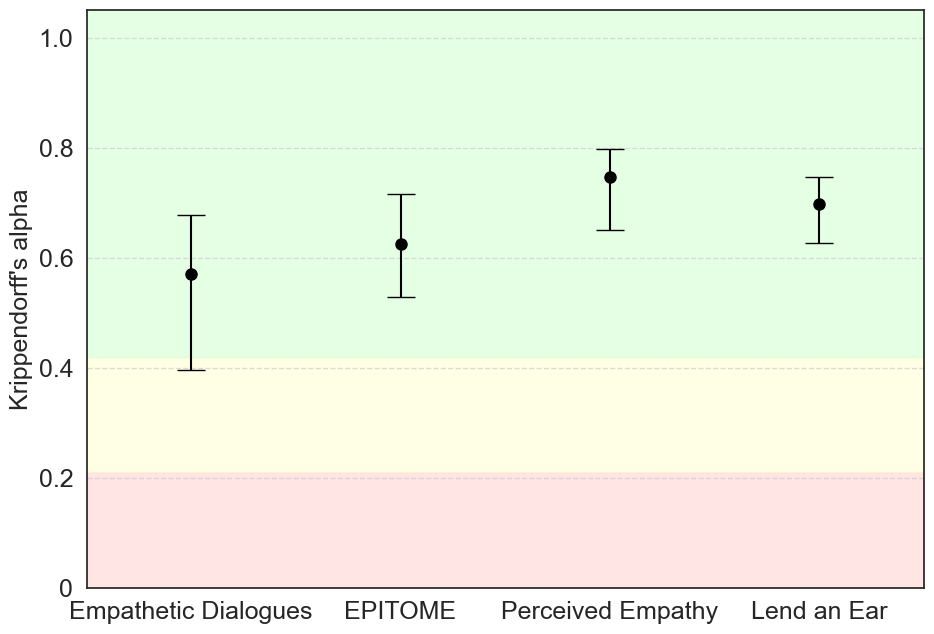

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


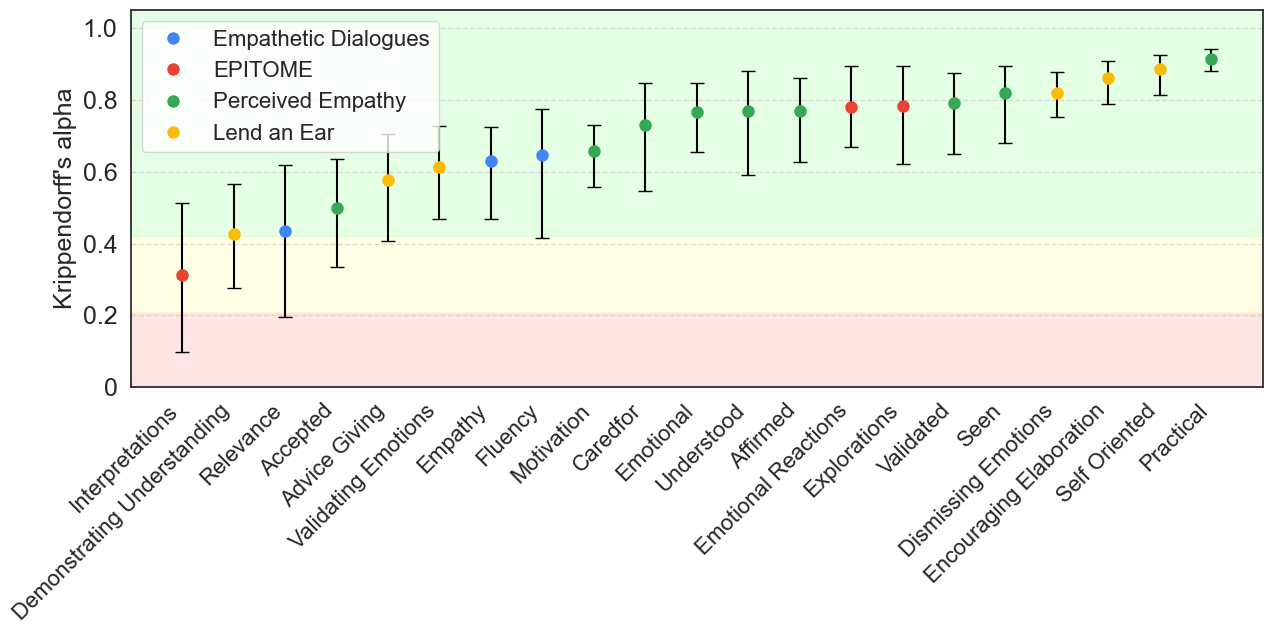

In [14]:
df = pd.read_csv("annotations/combined_annotations_across_methods_and_datasets.csv")

def calculate_krippendorfs_alpha_manual_llm(df, dimension, dataset_id_column):
    """Manual implementation of Krippendorf's alpha for three llm annotators."""
    gemini_data = df[df['annotation_method'] == 'gemini'][[dataset_id_column, dimension]].set_index(dataset_id_column)
    gpt_data = df[df['annotation_method'] == 'gpt'][[dataset_id_column, dimension]].set_index(dataset_id_column)
    claude_data = df[df['annotation_method'] == 'claude'][[dataset_id_column, dimension]].set_index(dataset_id_column)
    
    
    # Join the data
    combined_data = pd.concat([
        gemini_data.rename(columns={dimension: 'gemini'}),
        gpt_data.rename(columns={dimension: 'gpt'}),
        claude_data.rename(columns={dimension: 'claude'})
    ], axis=1)
    
    # Convert to numeric and handle missing values
    for col in ['gemini', 'gpt', 'claude']:
        combined_data[col] = pd.to_numeric(combined_data[col], errors='coerce')
    
    combined_data = combined_data.dropna(how='all')
    sample_size = len(combined_data)
    
    if sample_size < 2:
        return np.nan, 0
    
    # Prepare data array
    data = combined_data[['gemini', 'gpt', 'claude']].values.T
    
    # Calculate observed disagreement
    observed_disagreement = 0
    n_values = 0
    
    for item_idx in range(data.shape[1]):
        item_data = data[:, item_idx]
        valid_values = item_data[~np.isnan(item_data)]
        n_valid = len(valid_values)
        
        if n_valid < 2:
            continue
            
        for i in range(n_valid):
            for j in range(i+1, n_valid):
                observed_disagreement += (valid_values[i] - valid_values[j])**2
                n_values += 1
    
    if n_values == 0:
        return np.nan, sample_size
        
    observed_disagreement /= n_values
    
    # Calculate expected disagreement
    all_valid_values = data[~np.isnan(data)]
    if len(all_valid_values) < 2:
        return np.nan, sample_size
        
    expected_disagreement = 0
    n_pairs = len(all_valid_values) * (len(all_valid_values) - 1)
    
    if n_pairs == 0:
        return np.nan, sample_size
        
    for i in range(len(all_valid_values)):
        for j in range(len(all_valid_values)):
            if i != j:
                expected_disagreement += (all_valid_values[i] - all_valid_values[j])**2
    
    expected_disagreement /= n_pairs
    
    # Calculate alpha
    if expected_disagreement == 0:
        return 1.0, sample_size  # Perfect agreement
    
    alpha = 1 - (observed_disagreement / expected_disagreement)
    return alpha, sample_size

def bootstrap_all_alphas(df, dataset_info, n_bootstrap=1000, confidence=0.95):
    """
    Calculate both dataset-level and dimension-level bootstrapped confidence intervals 
    for Krippendorff's alpha in a single pass.
    
    Parameters:
    - df: DataFrame containing annotations
    - dataset_info: List of dictionaries with dataset information
    - n_bootstrap: Number of bootstrap samples
    - confidence: Confidence level for intervals
    
    Returns:
    - dataset_results: Dictionary with dataset-level results
    - dimension_results: List of dictionaries with dimension-level results
    """
    # Initialize results containers
    dataset_results = {}
    dimension_results = []
    
    # Process each dataset
    for dataset in dataset_info:
        dataset_name = dataset['display_name']
        dimensions = dataset['dimensions']
        dataset_id_column = dataset['id_column']
        print(f"\nCalculating bootstrapped Krippendorff's alpha for {dataset_name}...")
        
        # Get all sample IDs for bootstrapping
        all_ids = df[df['annotation_method'].isin(['gemini', 'gpt', 'claude'])][dataset_id_column].unique()
        if len(all_ids) < 5:
            print(f"Warning: Only {len(all_ids)} unique IDs found - bootstrapping may be unreliable")
            continue
        
        # Calculate original alphas for each dimension
        orig_alphas = {}
        sample_sizes = []
        dimension_bootstrap_data = {}  
        
        for dimension in dimensions:
            try:
                # Calculate original alpha for this dimension
                alpha, n = calculate_krippendorfs_alpha_manual_llm(df, dimension, dataset_id_column)
                orig_alphas[dimension] = alpha
                sample_sizes.append(n)
                
                # Only bootstrap if we have a valid alpha value
                if not np.isnan(alpha) and n >= 5:
                    # Store for dimension-level results
                    clean_dim = dimension.replace('level_', '').replace('m_', '').replace('_', ' ')
                    clean_dim = ' '.join(word.capitalize() for word in clean_dim.split())
                    
                    dimension_bootstrap_data[dimension] = {
                        'original_alpha': alpha,
                        'bootstrap_alphas': [],
                        'sample_size': n,
                        'clean_name': clean_dim,
                        'dataset': dataset_name
                    }
                
            except Exception as e:
                print(f"Error calculating alpha for {dimension}: {e}")
                orig_alphas[dimension] = np.nan
        
        valid_alphas = [a for a in orig_alphas.values() if not np.isnan(a)]
        if not valid_alphas:
            print(f"No valid alpha values for {dataset_name}, skipping")
            continue
        
        mean_alpha = np.mean(valid_alphas)
        
        # Bootstrap samples - resample conversations for both levels
        bootstrap_means = [] 
        
        for _ in range(n_bootstrap):
            # Resample IDs with replacement
            bootstrap_ids = resample(all_ids, replace=True, n_samples=len(all_ids))
            
            # Filter data to include only bootstrap samples
            bootstrap_df = df[df[dataset_id_column].isin(bootstrap_ids)]
            
            # Calculate alpha for each dimension in this bootstrap sample
            bootstrap_alphas = []
            
            for dimension in dimensions:
                if dimension in dimension_bootstrap_data:
                    alpha, _ = calculate_krippendorfs_alpha_manual_llm(bootstrap_df, dimension, dataset_id_column)
                    
                    if not np.isnan(alpha):
                        # For dataset-level
                        bootstrap_alphas.append(alpha)
                        
                        # For dimension-level
                        dimension_bootstrap_data[dimension]['bootstrap_alphas'].append(alpha)
        
            # Calculate mean alpha for this bootstrap sample (dataset-level)
            if bootstrap_alphas:
                bootstrap_means.append(np.mean(bootstrap_alphas))
        
        # Calculate dataset-level confidence intervals
        if len(bootstrap_means) >= 10:
            alpha_level = (1 - confidence) / 2
            ci_lower_dataset = max(0, np.percentile(bootstrap_means, 100 * alpha_level))
            ci_upper_dataset = min(1, np.percentile(bootstrap_means, 100 * (1 - alpha_level)))
        else:
            print(f"Warning: Only {len(bootstrap_means)} valid bootstrap samples for {dataset_name}")
            ci_lower_dataset = np.nan
            ci_upper_dataset = np.nan
        
        # Store dataset-level results
        dataset_results[dataset_name] = {
            "alphas_by_dimension": orig_alphas,
            "mean_alpha": mean_alpha,
            "ci_lower": ci_lower_dataset,
            "ci_upper": ci_upper_dataset,
            "sample_size": np.mean(sample_sizes) if sample_sizes else 0
        }
        
        # Calculate dimension-level confidence intervals and store results
        for dimension, dim_data in dimension_bootstrap_data.items():
            bootstrap_values = dim_data['bootstrap_alphas']
            
            if len(bootstrap_values) >= 10:
                ci_lower_dim = max(0, np.percentile(bootstrap_values, 100 * alpha_level))
                ci_upper_dim = min(1, np.percentile(bootstrap_values, 100 * (1 - alpha_level)))
            else:
                ci_lower_dim = np.nan
                ci_upper_dim = np.nan
            
            dimension_results.append({
                'dataset': dim_data['dataset'],
                'dimension': dimension,
                'clean_name': dim_data['clean_name'],
                'alpha': dim_data['original_alpha'],
                'ci_lower': ci_lower_dim,
                'ci_upper': ci_upper_dim,
                'sample_size': dim_data['sample_size']
            })
        
        # Print dimension-level alphas
        for dim, alpha in orig_alphas.items():
            print(f"  {dim}: alpha={alpha:.3f}")
        
        # Print dataset-level results with bootstrap CIs
        print(f"  Dataset mean alpha: {mean_alpha:.3f}, 95% CI: [{ci_lower_dataset:.3f}, {ci_upper_dataset:.3f}]")
    
    return dataset_results, dimension_results

# Define dataset information
dataset_info = [
    {
        'key': 'empatheticdialogues',
        'display_name': 'Empathetic Dialogues',
        'id_column': 'empathetic_conversation_id',
        'dimensions': ['empathy', 'fluency', 'relevance']
    },
    {
        'key': 'epitome',
        'display_name': 'EPITOME',
        'id_column': 'epitome_conversation_id',
        'dimensions': ['level_emotional_reactions', 'level_explorations', 'level_interpretations']
    },
    {
        'key': 'perceived_empathy',
        'display_name': 'Perceived Empathy',
        'id_column': 'perceived_conversation_id',
        'dimensions': ['m_understood', 'm_validated', 'm_affirmed', 'm_seen', 
                      'm_accepted', 'm_caredfor', 'm_emotional', 'm_practical', 'm_motivation']
    },
    {
        'key': 'lend_an_ear',
        'display_name': 'Lend an Ear',
        'id_column': 'lend_an_ear_conversation_id',
        'dimensions': ['validating_emotions', 'encouraging_elaboration', 'demonstrating_understanding',
                      'self_oriented', 'advice_giving', 'dismissing_emotions']
    }
]



# Run the combined bootstrapping function once
dataset_results, dimension_results = bootstrap_all_alphas(df, dataset_info)

# Convert dimension results to DataFrame and sort
dim_df = pd.DataFrame(dimension_results)
dim_df = dim_df.sort_values('alpha', ascending=True)

# Define colors for datasets
dataset_colors = {
    'Empathetic Dialogues': '#4285F4',  # Blue
    'EPITOME': '#EA4335',               # Red
    'Perceived Empathy': '#34A853',     # Green
    'Lend an Ear': '#FBBC05'            # Yellow
}

fig1, ax1 = plt.subplots(figsize=(9.5, 6.5))

ax1.add_patch(Rectangle((0, 0), 1, 0.2, transform=ax1.transAxes, color='#ffcccb', alpha=0.5, zorder=0))
ax1.add_patch(Rectangle((0, 0.2), 1, 0.2, transform=ax1.transAxes, color='#ffffcc', alpha=0.5, zorder=0))
ax1.add_patch(Rectangle((0, 0.4), 1, 0.6, transform=ax1.transAxes, color='#ccffcc', alpha=0.5, zorder=0))

display_names = [dataset['display_name'] for dataset in dataset_info]
x_pos = range(len(display_names))

mean_alphas = [dataset_results[name]["mean_alpha"] for name in display_names]

# Calculate error bar components with clipping for non-negativity
y_err_components = []
for name in display_names:
    mean_val = dataset_results[name]["mean_alpha"]
    ci_low = dataset_results[name]["ci_lower"]
    ci_high = dataset_results[name]["ci_upper"]
    
    err_low_raw = mean_val - ci_low
    err_high_raw = ci_high - mean_val
    
    err_low_clipped = np.maximum(0, err_low_raw)
    err_high_clipped = np.maximum(0, err_high_raw)
    
    y_err_components.append((err_low_clipped, err_high_clipped))

error_bars = np.array(y_err_components).T # Transpose to get the 2xN shape required by yerr

ax1.errorbar(x_pos, mean_alphas, yerr=error_bars, fmt='o', color='black', 
            ecolor='black', capsize=10, markersize=8)

ax1.set_ylabel("Krippendorff's alpha", fontsize=18)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(display_names, rotation=0, fontsize=18)
ax1.set_ylim(0, 1.05)
ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax1.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=18)
ax1.set_xlim(-0.5, len(display_names) - 0.5)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig("figs/llm_krippendorffs_alpha_by_dataset_bootstrapped.png", dpi=300, bbox_inches="tight")
plt.show()

fig2, ax2 = plt.subplots(figsize=(13, 6.5))

# Add colored background for agreement levels
ax2.add_patch(Rectangle((0, 0), 1, 0.2, transform=ax2.transAxes, color='#ffcccb', alpha=0.5, zorder=0))
ax2.add_patch(Rectangle((0, 0.2), 1, 0.2, transform=ax2.transAxes, color='#ffffcc', alpha=0.5, zorder=0))
ax2.add_patch(Rectangle((0, 0.4), 1, 0.6, transform=ax2.transAxes, color='#ccffcc', alpha=0.5, zorder=0))

x_pos = np.arange(len(dim_df))

for i, (_, row) in enumerate(dim_df.iterrows()):
    color = dataset_colors[row['dataset']]
    
    if np.isnan(row['ci_lower']) or np.isnan(row['ci_upper']):
        ax2.plot(x_pos[i], row['alpha'], 'o', color=color, markersize=8)
    else:
        # Calculate raw error magnitudes
        err_low_raw = row['alpha'] - row['ci_lower']
        err_high_raw = row['ci_upper'] - row['alpha']
        
        # Ensure error magnitudes are non-negative
        err_low_clipped = np.maximum(0, err_low_raw)
        err_high_clipped = np.maximum(0, err_high_raw)
        
        yerr_clipped = [[err_low_clipped], [err_high_clipped]]
        
        ax2.errorbar(x_pos[i], row['alpha'], yerr=yerr_clipped, fmt='o', 
                    color=color, ecolor='black', capsize=5, markersize=8)

# Set labels and limits
ax2.set_ylabel("Krippendorff's alpha", fontsize=18)
ax2.set_xlabel("", fontsize=18)
ax2.set_ylim(0, 1.05)
ax2.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax2.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=18)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(dim_df['clean_name'].tolist(), rotation=45, ha='right', fontsize=16)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# Create legend
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10)
                 for dataset, color in dataset_colors.items()]
ax2.legend(legend_handles, dataset_colors.keys(), title="", 
          loc='upper left', fontsize=16, title_fontsize=16)

plt.tight_layout()
plt.savefig("figs/ExtendedDataFigure3.eps", dpi=300, bbox_inches="tight")
plt.show()

/var/folders/2d/fp_xlbjs1pndxz4df7hd6f500000gp/T/ipykernel_15826/873405276.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(
/var/folders/2d/fp_xlbjs1pndxz4df7hd6f500000gp/T/ipykernel_15826/873405276.py:109: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(method_labels, fontsize=25, ha='center')
/var/folders/2d/fp_xlbjs1pndxz4df7hd6f500000gp/T/ipykernel_15826/873405276.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(
/var/folders/2d/fp_xlbjs1pndxz4df7hd6f500000gp/T/ipykernel_15826/873405276.py:109: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

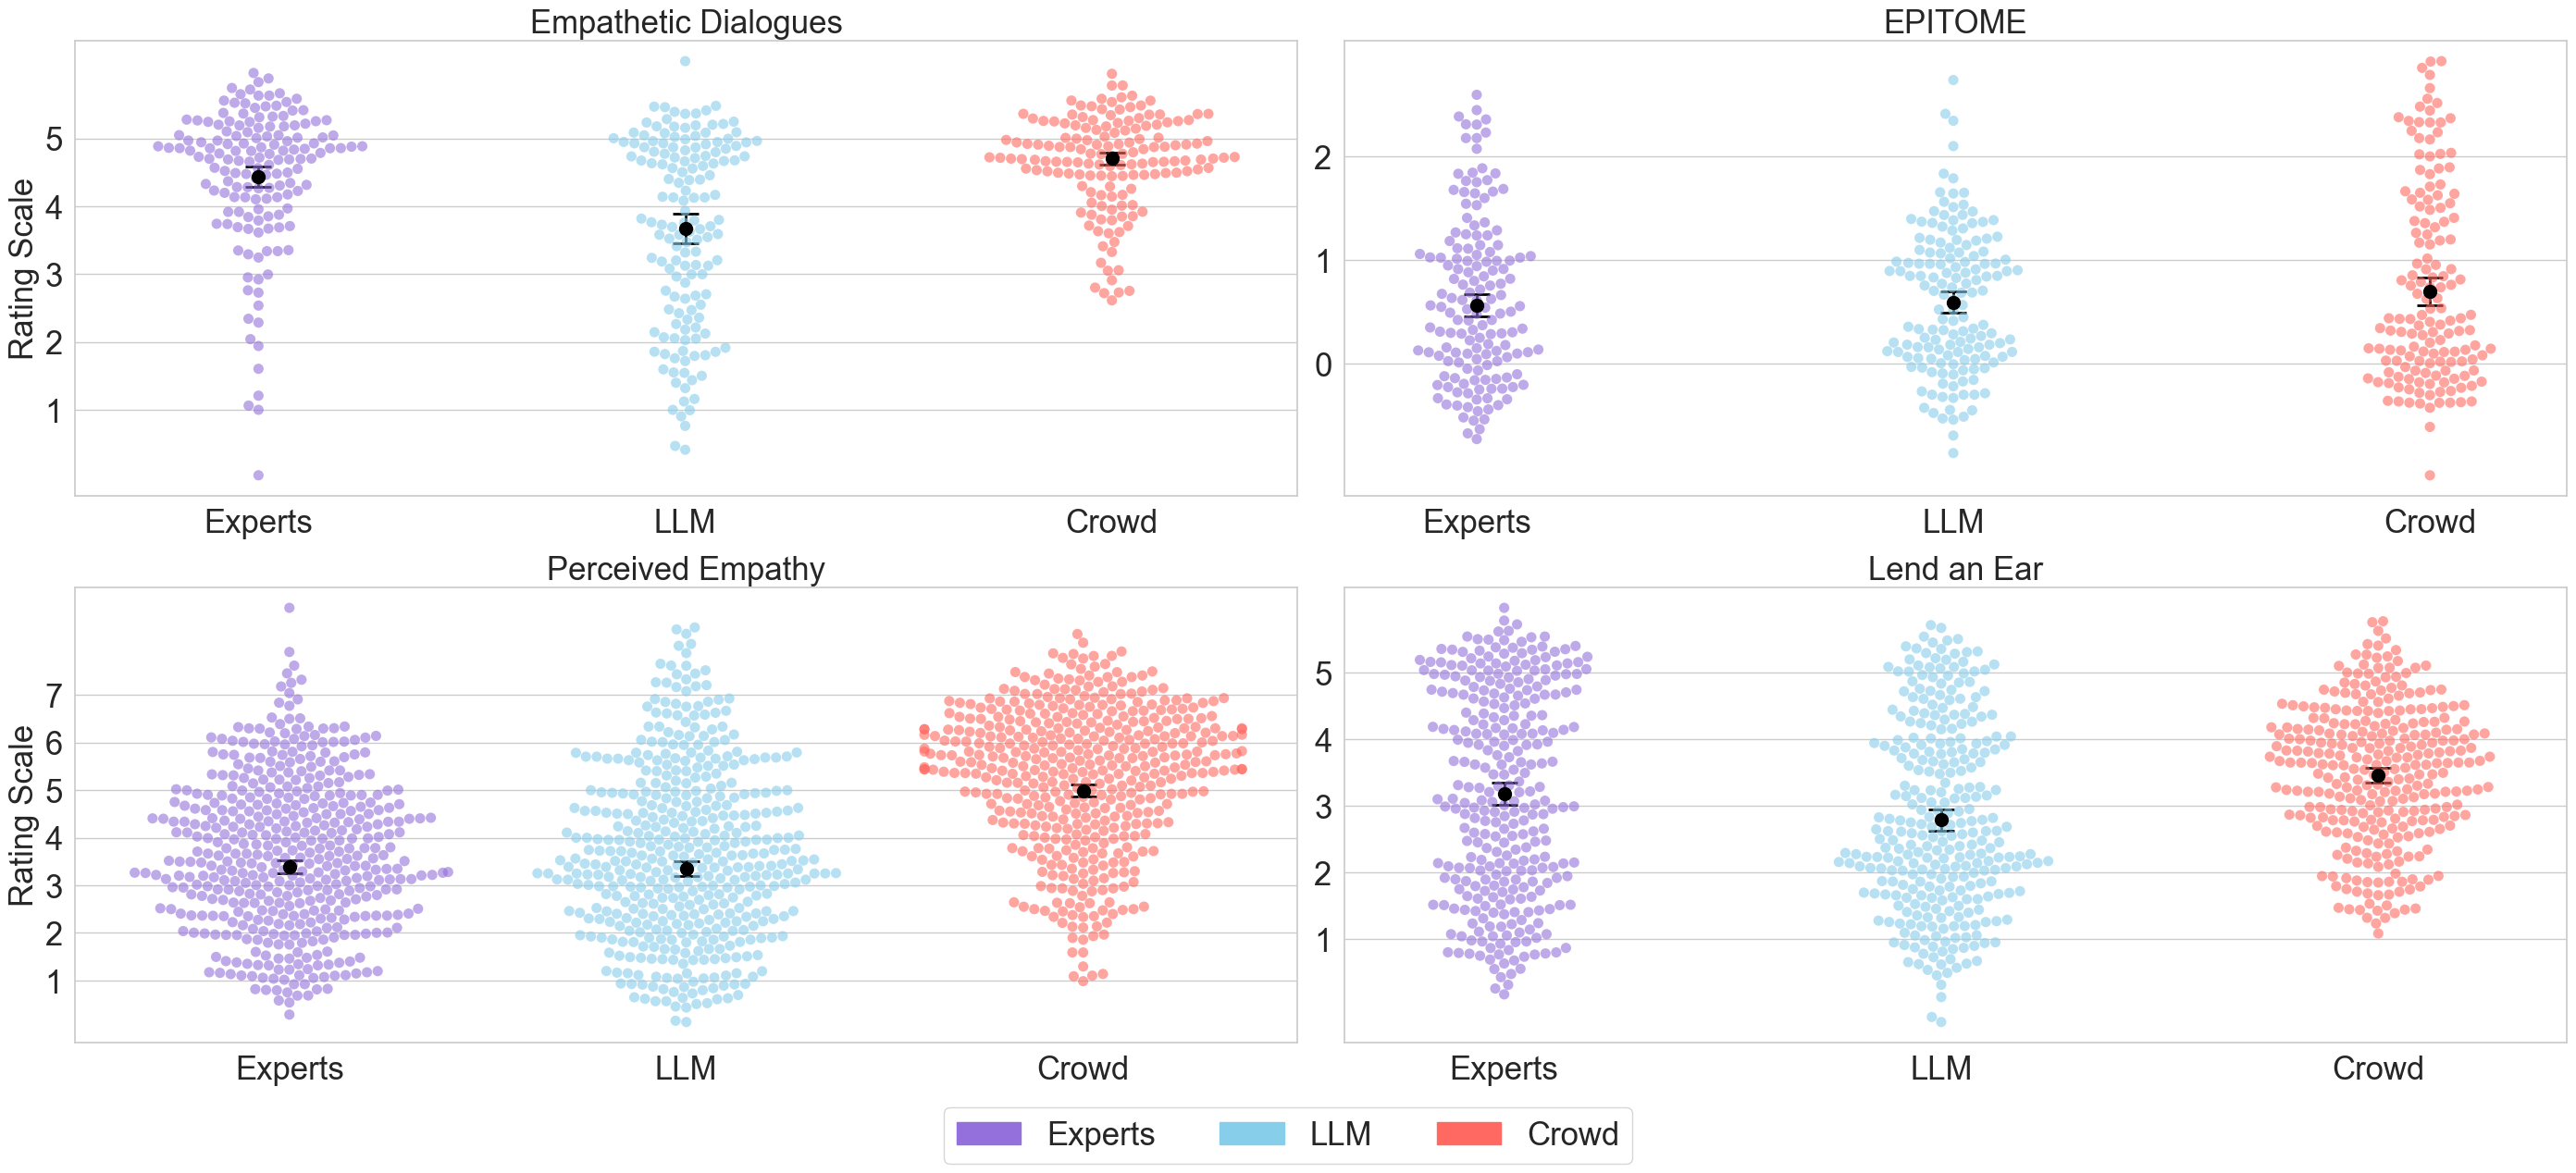

In [15]:
df = pd.read_csv("annotations/combined_annotations_across_methods_and_datasets.csv")


dataset_blocks = {
    "Empathetic Dialogues": {
        "dimensions": ["empathy", "fluency", "relevance"],
        "id_col": "empathetic_conversation_id"
    },
    "EPITOME": {
        "dimensions": ["level_emotional_reactions", "level_explorations", "level_interpretations"],
        "id_col": "epitome_conversation_id"
    },
    "Perceived Empathy": {
        "dimensions": [
            "m_understood", "m_validated", "m_affirmed", "m_seen", "m_accepted",
            "m_caredfor", "m_emotional", "m_practical", "m_motivation"
        ],
        "id_col": "perceived_conversation_id"
    },
    "Lend an Ear": {
        "dimensions": [
            "validating_emotions", "encouraging_elaboration", "demonstrating_understanding",
            "advice_giving", "self_oriented", "dismissing_emotions"
        ],
        "id_col": "lend_an_ear_conversation_id"
    }
}

# for Lend an Ear, reverse code "advice_giving", "self_oriented", "dismissing_emotions"
df["advice_giving"] = 6 - df["advice_giving"]
df["self_oriented"] = 6 - df["self_oriented"]
df["dismissing_emotions"] = 6 - df["dismissing_emotions"]

all_rows = []
for dataset, info in dataset_blocks.items():
    # create blocks based on dimensions and id_col
    block = df[df["annotation_method"].isin(["experts", "llm", "crowd"])][["annotation_method", info["id_col"]] + info["dimensions"]]
    rating_cols = [col for col in block.columns if col in info["dimensions"]]
    # Use the global annotation_method column
    block["annotation_method"] = df["annotation_method"]
    
    # Convert ratings to numeric
    block[rating_cols] = block[rating_cols].apply(pd.to_numeric, errors='coerce')
    
    # Normalize method names for consistency
    block["annotation_method"] = block["annotation_method"].str.lower().replace({
        "experts_mode": "experts", "llm": "llm", "crowd": "crowd"
    })
    
    block = block[block["annotation_method"].isin(["experts", "llm", "crowd"])].copy()
    
    # Reshape data to long format with each dimension as a separate row
    for dim in rating_cols:
        dim_data = block[["annotation_method", info["id_col"], dim]].copy()
        dim_data["Dataset"] = dataset
        dim_data["dimension"] = dim
        dim_data.rename(columns={dim: "score"}, inplace=True)
        all_rows.append(dim_data)

# Combine all data
plot_df = pd.concat(all_rows, ignore_index=True)
plot_df["score"] = pd.to_numeric(plot_df["score"], errors='coerce')
plot_df.rename(columns={"annotation_method": "Method"}, inplace=True)

# Set categorical order for plotting
dataset_order = ["Empathetic Dialogues", "EPITOME", "Perceived Empathy", "Lend an Ear"]
method_order = ["experts", "llm", "crowd"]
method_labels = ["Experts", "LLM", "Crowd"]

# Define colors for methods
palette = {'experts': '#9370DB', 'llm': '#87CEEB', 'crowd': '#FF6961'}  # Purple, Light Blue, Red

# Define y-axis limits for each dataset
y_axis_ticks = {
    "Empathetic Dialogues": [1, 2, 3, 4, 5],
    "EPITOME": [0, 1, 2],
    "Perceived Empathy": [1, 2, 3, 4, 5, 6, 7],
    "Lend an Ear": [1, 2, 3, 4, 5]
}

# Set theme
sns.set_theme(style="whitegrid")

# Create figure
fig, axes = plt.subplots(2, 2, figsize=(28, 12), sharey=False)  # 1x4 layout

# Plot swarmplots for each dataset
for i, (ax, dname) in enumerate(zip(axes.flatten(), dataset_order)):
    data_subset = plot_df[plot_df["Dataset"] == dname].dropna(subset=["score"])
    jitter_strength = .4
    x_jitter = 0
    if dname == "Perceived Empathy":
        jitter_strength = .6
        x_jitter = .25
    y_vals = data_subset['score'] + np.random.normal(x_jitter, jitter_strength, size=len(data_subset))
    if not data_subset.empty:
        sns.swarmplot(
            x="Method", 
            y=y_vals, 
            data=data_subset,
            palette=palette,
            size=8, 
            ax=ax,
            order=method_order,
            alpha=0.6
        )
        
        # Set x-tick labels
        ax.set_xticklabels(method_labels, fontsize=25, ha='center')
        
        # Set y-axis limits and ticks based on the dataset
        ax.set_yticks(y_axis_ticks[dname])
        ax.set_yticklabels(y_axis_ticks[dname], fontsize=25)
        
        # Set title and label
        ax.set_title(dname, fontsize=25)
        ax.set_xlabel("")

        # Add black dots for mean scores of each method
        for method_idx, method in enumerate(method_order):
            method_data = data_subset[data_subset["Method"] == method]
            if not method_data.empty:
                method_mean = np.mean(method_data["score"])
                ax.scatter(method_idx, method_mean, color='black', marker='o', s=100, zorder=4)

                 # Calculate 95% confidence interval
                if len(method_data["score"]) > 1:
                    se = stats.sem(method_data["score"])
                    ci_95 = se * stats.t.ppf((1 + 0.95) / 2, len(method_data["score"]) - 1)
                else:
                    ci_95 = 0
                                
                # Plot 95% CI as error bars
                ax.errorbar(method_idx, method_mean, yerr=ci_95, 
                           color='black', capsize=10, capthick=2, 
                           linewidth=2, zorder=2)
        
        # Only add y-label to the first plot
        if i == 0 or i == 2:
            ax.set_ylabel("Rating Scale", fontsize=25)
        else:
            ax.set_ylabel("")

# Create a custom legend
handles = [
    mpatches.Patch(color=palette['experts'], label='Experts'),
    mpatches.Patch(color=palette['llm'], label='LLM'),
    mpatches.Patch(color=palette['crowd'], label='Crowd')
]
fig.legend(handles=handles, loc='lower center', ncol=3, fontsize=25, bbox_to_anchor=(0.5, -0.07))

plt.tight_layout()
plt.savefig("figs/ExtendedDataFigure5.eps", dpi=300, bbox_inches="tight")
plt.show()

/var/folders/2d/fp_xlbjs1pndxz4df7hd6f500000gp/T/ipykernel_15826/2866175920.py:95: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Weighted Cohen's Kappa percentiles (25th, 50th, 75th): [0.49  0.58  0.655]


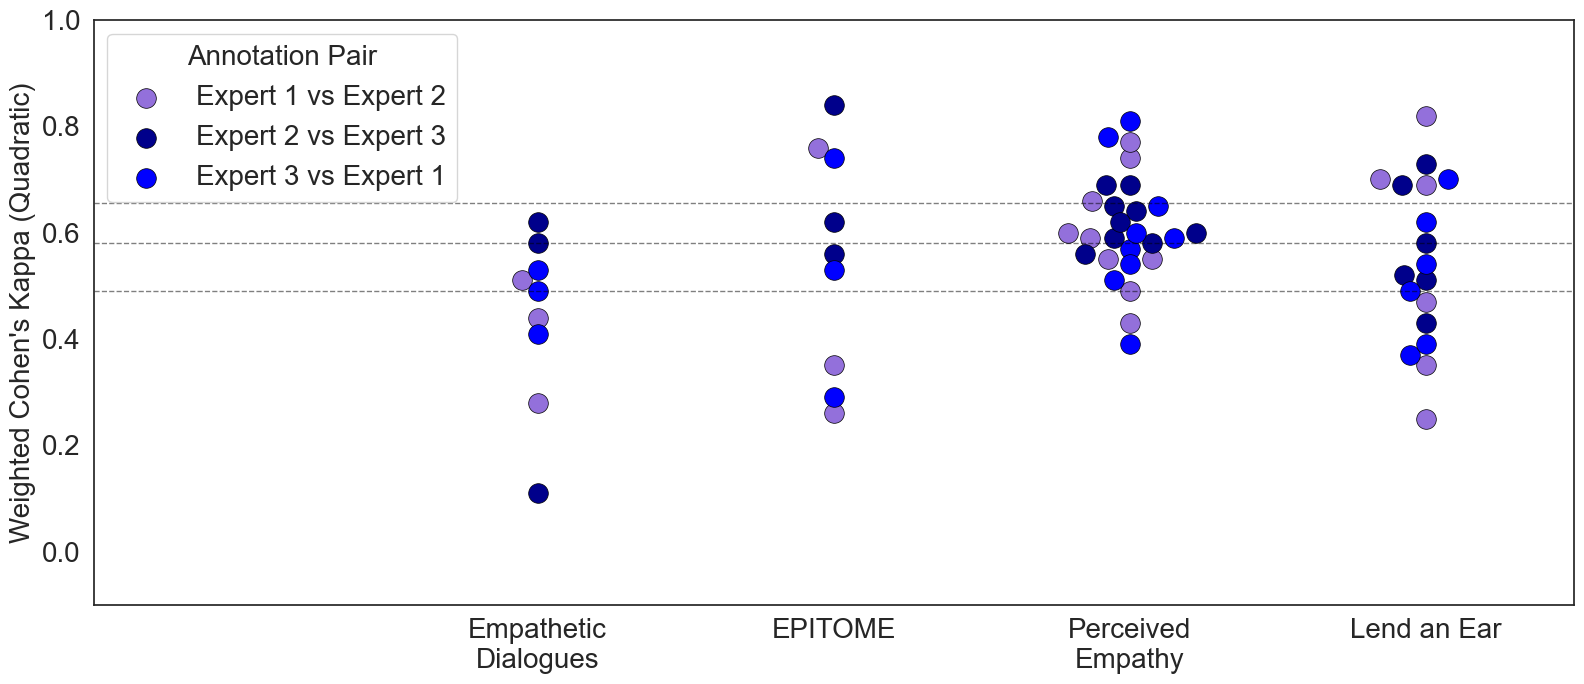

In [16]:
kappa = pd.read_csv("annotations/all_annotator_pairs_spearman_kappa.csv")

expert_pairs_to_filter = [
    "('expert1', 'expert2')",
    "('expert2', 'expert3')",
    "('expert3', 'expert1')"
]
kappa = kappa[kappa['Annotator Pair'].isin(expert_pairs_to_filter)]
percentiles = np.percentile(kappa["Weighted Cohen's Kappa"].values.astype(float), [25, 50, 75])
print("Weighted Cohen's Kappa percentiles (25th, 50th, 75th):", percentiles)
sns.set_style("white")

label_mapping = {
    "('expert1', 'expert2')": "Expert 1 vs Expert 2",
    "('expert2', 'expert3')": "Expert 2 vs Expert 3",
    "('expert3', 'expert1')": "Expert 3 vs Expert 1",

}

plot_data = kappa.copy()
plot_data["Annotator Pair"] = plot_data["Annotator Pair"].replace(label_mapping)
plot_data["Weighted Cohen's Kappa"] = plot_data["Weighted Cohen's Kappa"].astype(float)



colors = {
    "Expert 1 vs Expert 2": "#9370DB",         # Purple
    "Expert 2 vs Expert 3": "darkblue", # Red
    "Expert 3 vs Expert 1": "blue",   # Light Blue
}

marker_mapping = {"Expert 1 vs Expert 2": "o", "Expert 2 vs Expert 3": "o", "Expert 3 vs Expert 1": "o" }


hue_order = ["Expert 1 vs Expert 2", "Expert 2 vs Expert 3", "Expert 3 vs Expert 1"]
dataset_order = ["Empathetic Dialogues", "EPITOME", "Perceived Empathy", "Lend an Ear"]

plt.figure(figsize=(10, 7))
ax = sns.swarmplot(
    data=plot_data,
    x="Dataset",
    y="Weighted Cohen's Kappa",
    hue="Annotator Pair",
    hue_order=hue_order,
    order=dataset_order,
    palette=colors,
    size=13
)

# Get the positions from the swarmplot
points_by_hue = {hue: [] for hue in hue_order}

# For each dataset's collection
for dataset_idx, collection in enumerate(ax.collections):
    positions = collection.get_offsets().data
    points_per_hue = len(positions) // len(hue_order)
    
    # Split the positions among the hue values
    for hue_idx, hue in enumerate(hue_order):
        start_idx = hue_idx * points_per_hue
        end_idx = start_idx + points_per_hue
        hue_positions = positions[start_idx:end_idx]
        points_by_hue[hue].append(hue_positions)

plt.close()

# Create final plot
fig, ax = plt.subplots(figsize=(16, 7))

for hue in hue_order:
    # add some jitter to the points
    all_positions = np.vstack(points_by_hue[hue])
    ax.scatter(
        all_positions[:, 0],
        all_positions[:, 1],
        marker=marker_mapping[hue],
        c=colors[hue],
        s=200,
        edgecolor='black',
        linewidth=0.5,
        label=hue
    )

plt.axhline(y=percentiles[0], color='black', linestyle='--', linewidth=1, alpha=0.5)
plt.axhline(y=percentiles[1], color='black', linestyle='--', linewidth=1, alpha=0.5)
plt.axhline(y=percentiles[2], color='black', linestyle='--', linewidth=1, alpha=0.5)


# Customize plot
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(
    ["Empathetic\nDialogues", "EPITOME", "Perceived\nEmpathy", "Lend an Ear"],
    fontsize=20
)
ax.set_yticklabels(
    ["-0.1", "0.0", "0.2", "0.4",  "0.6",  "0.8", "1.0"],
    fontsize=20
)
plt.xlabel("")
plt.ylabel("Weighted Cohen's Kappa (Quadratic)", fontsize=20)

# Handle legend to avoid duplicates
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(
    by_label.values(),
    by_label.keys(),
    title="Annotation Pair",
    loc="upper left",
    frameon=True,
    fontsize=20,
    title_fontsize=20
)

plt.xlim(-1.5, 3.5)
plt.ylim(-0.1, 1)
plt.tight_layout()

plt.savefig("figs/ExtendedDataFigure1.eps", dpi=300, bbox_inches="tight")
plt.show()


/var/folders/2d/fp_xlbjs1pndxz4df7hd6f500000gp/T/ipykernel_15826/4094317265.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.swarmplot(
/var/folders/2d/fp_xlbjs1pndxz4df7hd6f500000gp/T/ipykernel_15826/4094317265.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(method_order, fontsize=14)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


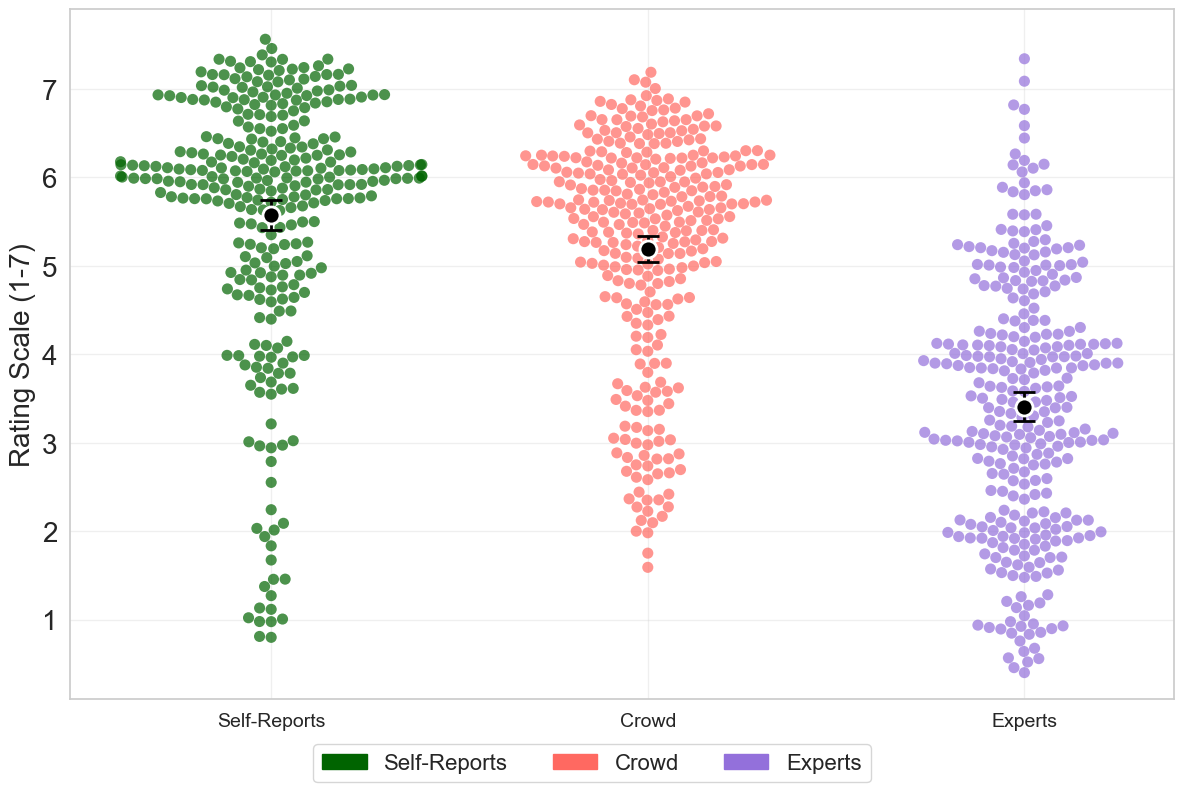

In [17]:
self = pd.read_csv("original_data/perceived_empathy_self_ratings.csv")
crowd = pd.read_csv("annotations/perceived_empathy/crowd_ratings.csv")
expert1 = pd.read_csv("annotations/perceived_empathy/expert1_ratings.csv")
expert2 = pd.read_csv("annotations/perceived_empathy/expert2_ratings.csv")
expert3 = pd.read_csv("annotations/perceived_empathy/expert3_ratings.csv")

self = self[['id','understood','validated','affirmed','seen','accepted','caredfor']]
crowd = crowd[['id','m_understood','m_validated','m_affirmed','m_seen','m_accepted','m_caredfor']]
self.columns = ['id','m_understood','m_validated','m_affirmed','m_seen','m_accepted','m_caredfor']
self = self[self['id'].isin(crowd['id'])]

self = self.sort_values(by='id')
crowd = crowd.sort_values(by='id')
expert1 = expert1.sort_values(by='id')
expert2 = expert2.sort_values(by='id')
expert3 = expert3.sort_values(by='id')

expert_combined = expert1[['id','m_understood','m_validated','m_affirmed','m_seen','m_accepted','m_caredfor']].copy()
for col in ['m_understood','m_validated','m_affirmed','m_seen','m_accepted','m_caredfor']:
    expert_combined[col] = np.median([expert1[col], expert2[col], expert3[col]], axis=0).astype(int)
expert_combined = expert_combined.sort_values(by='id')

rating_cols = ['m_understood','m_validated','m_affirmed','m_seen','m_accepted','m_caredfor']
all_ratings = []

methods = {
    'Self-Reports': self,
    'Crowd': crowd,
    'Experts': expert_combined
}

for method_name, df in methods.items():
    for col in rating_cols:
        for idx, row in df.iterrows():
            all_ratings.append({
                'Method': method_name,
                'Score': row[col],
                'Dimension': col.replace('m_', '').title(),
                'ID': row['id']
            })

plot_df = pd.DataFrame(all_ratings)
plot_df['Score'] = pd.to_numeric(plot_df['Score'], errors='coerce')
plot_df = plot_df.dropna(subset=['Score'])

method_order = ['Self-Reports', 'Crowd', 'Experts']
palette = {'Self-Reports': 'darkgreen', 'Crowd': '#FF6961', 'Experts': '#9370DB'}

sns.set_theme(style="whitegrid")

plt.figure(figsize=(12, 8))

jitter_strength = 0.25
plot_df_jittered = plot_df.copy()
plot_df_jittered['Score_jittered'] = plot_df_jittered['Score'] + np.random.normal(0, jitter_strength, size=len(plot_df_jittered))

ax = sns.swarmplot(
    x="Method", 
    y="Score_jittered", 
    data=plot_df_jittered,
    palette=palette,
    size=8, 
    order=method_order,
    alpha=0.7
)

for method_idx, method in enumerate(method_order):
    method_data = plot_df[plot_df["Method"] == method]["Score"]
    if not method_data.empty:
        method_mean = np.mean(method_data)
        ax.scatter(method_idx, method_mean, color='black', marker='o', s=150, zorder=4, edgecolors='white', linewidth=2)

        if len(method_data) > 1:
            se = stats.sem(method_data)
            ci_95 = se * stats.t.ppf((1 + 0.95) / 2, len(method_data) - 1)
        else:
            ci_95 = 0
                        
        ax.errorbar(method_idx, method_mean, yerr=ci_95, 
                   color='black', capsize=8, capthick=2, 
                   linewidth=2, zorder=3)

ax.set_xticklabels(method_order, fontsize=14)
ax.set_xlabel('', fontsize=14)
ax.set_ylabel('Rating Scale (1-7)', fontsize=20)
ax.set_ylim(0.1, 7.9)
ax.set_yticks([1, 2, 3, 4, 5, 6, 7])
ax.set_yticklabels([1, 2, 3, 4, 5, 6, 7], fontsize=20)
ax.grid(True, alpha=0.3)

handles = [
    mpatches.Patch(color=palette['Self-Reports'], label='Self-Reports'),
    mpatches.Patch(color=palette['Crowd'], label='Crowd'),
    mpatches.Patch(color=palette['Experts'], label='Experts')
]
ax.legend(handles=handles, bbox_to_anchor=(.22, -.12), loc='lower left', borderaxespad=0, ncol=3, fontsize=16, frameon=True)

plt.tight_layout()
plt.savefig('figs/ExtendedDataFigure6.eps', dpi=300, bbox_inches='tight')
plt.show()

In [24]:
#Contextual consistency in Lend an Ear annotations
data = pd.read_csv("annotations/combined_annotations_across_methods_and_datasets.csv")
conv = pd.read_csv("original_data/sample_lend_an_ear_conversations.csv")  

data["lend_an_ear_conversation_id"] = data["lend_an_ear_conversation_id"].astype(str)
methods_present = set(pd.Series(data["annotation_method"]).dropna().unique().tolist())

dims = [
    "validating_emotions",
    "encouraging_elaboration",
    "demonstrating_understanding",
    "advice_giving",
    "self_oriented",
    "dismissing_emotions",
]

keep_cols = ["lend_an_ear_conversation_id"] + dims
keep_cols = [c for c in keep_cols if c in data.columns]
data = data[keep_cols].copy()
for c in dims:
    if c in data.columns:
        data[c] = pd.to_numeric(data[c], errors="coerce")

agg = (
    data.groupby("lend_an_ear_conversation_id", as_index=False)[dims]
    .mean()
    .dropna(subset=["lend_an_ear_conversation_id"])
)

def first_seeker_turn(text):
    t = str(text)
    if "Seeker:" in t:
        after = t.split("Seeker:", 1)[1]
        before_supporter = after.split("Supporter:", 1)[0]
        return before_supporter.strip()
    return t.strip().splitlines()[0] if isinstance(t, str) else ""

def classify_context(utterance):
    u = utterance.lower()
    if "i just lost my job today" in u:
        return "job_loss"

    if "just got passed over for the promotion" in u:
        return "promotion_passed_over"

    if "been feeling so detached from everything lately" in u:
        return "overlooked_undervalued"
    return None

conv = conv.rename(columns={"conversation_id": "lend_an_ear_conversation_id"})
conv["lend_an_ear_conversation_id"] = conv["lend_an_ear_conversation_id"].astype(str)
conv["first_seeker"] = conv["full_conversation"].map(first_seeker_turn)
conv["context"] = conv["first_seeker"].map(classify_context)

context_map = conv.set_index("lend_an_ear_conversation_id")["context"].to_dict()
agg["context"] = agg["lend_an_ear_conversation_id"].map(context_map)


print(f"Total conversations with context: {agg['context'].notna().sum()}")
for context in ["job_loss", "promotion_passed_over", "overlooked_undervalued"]:
    count = (agg["context"] == context).sum()
    print(f"{context}: {count} conversations")

kw_rows = []

print("KRUSKAL-WALLIS TESTS PER DIMENSION")
for dim in dims:
    samples = [
        agg.loc[agg["context"] == context, dim].dropna().values
        for context in ["job_loss", "promotion_passed_over", "overlooked_undervalued"]
    ]

    kw_stat, p_val = kruskal(*samples)
    print(f"{dim.upper()}: H={kw_stat:.3f}, p={p_val:.4f}")

    kw_rows.append({
        "dimension": dim,
        "H_stat": kw_stat,
        "p_value": p_val,
    })

kw_results = pd.DataFrame(kw_rows)

mask = kw_results["p_value"].notna()
reject, p_adj, _, _ = multipletests(
    kw_results.loc[mask, "p_value"].values, method="fdr_bh"
)
kw_results.loc[mask, "p_adj"] = p_adj
kw_results.loc[mask, "significant_fdr_0.05"] = reject
print("KRUSKAL-WALLIS FDR CORRECTION")
print(f"Total sub-components tested: {len(kw_results)}")
print(f"Significant after FDR correction (α=0.05): {reject.sum()}")
print(kw_results)

Total conversations with context: 50
job_loss: 12 conversations
promotion_passed_over: 19 conversations
overlooked_undervalued: 19 conversations
KRUSKAL-WALLIS TESTS PER DIMENSION
VALIDATING_EMOTIONS: H=2.706, p=0.2585
ENCOURAGING_ELABORATION: H=6.798, p=0.0334
DEMONSTRATING_UNDERSTANDING: H=2.496, p=0.2871
ADVICE_GIVING: H=1.241, p=0.5376
SELF_ORIENTED: H=1.152, p=0.5622
DISMISSING_EMOTIONS: H=3.106, p=0.2116
KRUSKAL-WALLIS FDR CORRECTION
Total sub-components tested: 6
Significant after FDR correction (α=0.05): 0
                     dimension    H_stat   p_value     p_adj  \
0          validating_emotions  2.706094  0.258452  0.430716   
1      encouraging_elaboration  6.797827  0.033410  0.200457   
2  demonstrating_understanding  2.495544  0.287144  0.430716   
3                advice_giving  1.241238  0.537612  0.562156   
4                self_oriented  1.151952  0.562156  0.562156   
5          dismissing_emotions  3.106100  0.211602  0.430716   

  significant_fdr_0.05  
0     

In [ ]:
self_df = pd.read_csv("original_data/perceived_empathy_self_ratings.csv")
crowd = pd.read_csv("annotations/perceived_empathy/crowd_ratings.csv")
expert1 = pd.read_csv("annotations/perceived_empathy/expert1_ratings.csv")
expert2 = pd.read_csv("annotations/perceived_empathy/expert2_ratings.csv")
expert3 = pd.read_csv("annotations/perceived_empathy/expert3_ratings.csv")

ids50 = pd.read_csv("original_data/sample_perceived_empathy_annotations.csv")["OriginalDiscloserID"].unique()
self_df = self_df[self_df["id"].isin(ids50)]
crowd = crowd[crowd["id"].isin(ids50)]
expert1 = expert1[expert1["id"].isin(ids50)]
expert2 = expert2[expert2["id"].isin(ids50)]
expert3 = expert3[expert3["id"].isin(ids50)]

base_cols = ['m_understood','m_validated','m_affirmed','m_seen','m_accepted','m_caredfor']
self_df = self_df[['id','understood','validated','affirmed','seen','accepted','caredfor']].copy()
self_df.columns = ['id'] + base_cols

expert_combined = expert1[['id'] + base_cols].copy()
for col in base_cols:
    expert_combined[col] = np.median([expert1[col], expert2[col], expert3[col]], axis=0)

methods = {
    'Self-Reports': (self_df, base_cols),
    'Crowd': (crowd[['id'] + base_cols].copy(), base_cols),
    'Experts': (expert_combined[['id'] + base_cols].copy(), base_cols),
}

rows = []
for method_name, (df, cols) in methods.items():
    for _, r in df.iterrows():
        for col in cols:
            rows.append({
                'Method': method_name,
                'ID': r['id'],
                'Dimension': col.replace('m_', '').title(),
                'Score': r[col]
            })

plot_df = pd.DataFrame(rows)
plot_df['Score'] = pd.to_numeric(plot_df['Score'], errors='coerce')
plot_df = plot_df.dropna(subset=['Score'])

def ktau(a, b):
    return kendalltau(a, b, variant="b").correlation

def bootstrap_tau_ci(x, y, B=10000, seed=0):
    rng = np.random.default_rng(seed)
    n = len(x)
    if n < 5:
        return np.nan, (np.nan, np.nan)
    taus = np.empty(B)
    xi = x.to_numpy()
    yi = y.to_numpy()
    for i in range(B):
        idx = rng.integers(0, n, n)
        taus[i] = ktau(xi[idx], yi[idx])
    lo, hi = np.percentile(taus, [2.5, 97.5])
    return float(np.nanmean(taus)), (float(lo), float(hi))

def per_dimension_tau(df):
    dims = sorted(df["Dimension"].unique())
    out_rows = []
    for d in dims:
        sub = df[df["Dimension"] == d].groupby(["Method","ID"], as_index=False)["Score"].mean()
        self_id = sub[sub["Method"] == "Self-Reports"][["ID","Score"]].rename(columns={"Score":"Self"})
        row = {"Dimension": d}
        for method in ["Crowd", "Experts"]:
            other = sub[sub["Method"] == method][["ID","Score"]].rename(columns={"Score":method})
            merged = self_id.merge(other, on="ID", how="inner")
            row[f"{method}_tau"] = float(ktau(merged["Self"], merged[method]))
        out_rows.append(row)
    return pd.DataFrame(out_rows)

def collapsed_tau(df):
    out = {}
    self_sub = df[df["Method"] == "Self-Reports"][["ID","Dimension","Score"]].rename(columns={"Score": "Self"})
    for method in ["Crowd", "Experts"]:
        other = df[df["Method"] == method][["ID","Dimension","Score"]].rename(columns={"Score": method})
        merged = self_sub.merge(other, on=["ID","Dimension"], how="inner")
        tau = ktau(merged["Self"], merged[method])
        bmean, (lo, hi) = bootstrap_tau_ci(merged["Self"], merged[method], B=10000, seed=0)
        out[method] = {
            "tau": float(tau),
            "ci_lo": float(lo),
            "ci_hi": float(hi),
            "n_pairs": int(len(merged))
        }
    
    return out

print("Collapsed Kendall tau-b (Self vs Crowd, Self vs Experts) with 95% bootstrapped CIs")
coll = collapsed_tau(plot_df)
print({k: (v["tau"], (v["ci_lo"], v["ci_hi"]), v["n_pairs"]) for k, v in coll.items()})

dim_df = per_dimension_tau(plot_df)
print("Median crowd τb:", float(np.nanmedian(dim_df["Crowd_tau"])))
print("Median expert τb:", float(np.nanmedian(dim_df["Experts_tau"])))

In [ ]:
# VERBOSITY BIAS ANALYSIS 

# Load the response length data
lend_an_ear = pd.read_csv("original_data/sample_lend_an_ear_annotations.csv")
lend_an_ear_response_length = lend_an_ear[["conversation_id", "response_length"]].drop_duplicates()

epitome = pd.read_csv("original_data/sample_epitome.csv")
epitome_response_length = epitome[["rp_id", "response_length"]].drop_duplicates()

empathetic_dialogues = pd.read_csv("original_data/sample_empatheticdialogues.csv")
empathetic_dialogues_response_length = empathetic_dialogues[["conv_id", "response_length"]].drop_duplicates()

perceived_empathy = pd.read_csv("original_data/sample_perceived_empathy_annotations.csv")
perceived_empathy_response_length = perceived_empathy[["OriginalDiscloserID", "response_length"]].drop_duplicates()

# Load ratings data
ratings = pd.read_csv("annotations/combined_annotations_across_methods_and_datasets.csv")

# 1. Lend an Ear
lae = ratings[['lend_an_ear_conversation_id', 'validating_emotions', 'encouraging_elaboration',
               'demonstrating_understanding', 'advice_giving', 'self_oriented', 
               'dismissing_emotions', 'annotation_method']].copy()
lae = lae.dropna(subset=['lend_an_ear_conversation_id'])
lae = lae.rename(columns={'lend_an_ear_conversation_id': 'conversation_id'})
lae = lae.merge(lend_an_ear_response_length, on='conversation_id', how='inner')

# 2. Perceived Empathy
pe = ratings[['perceived_conversation_id', 'm_understood', 'm_validated', 'm_affirmed',
              'm_seen', 'm_accepted', 'm_caredfor', 'm_emotional', 'm_practical',
              'm_motivation', 'annotation_method.1']].copy()
pe = pe.dropna(subset=['perceived_conversation_id'])
pe = pe.rename(columns={'perceived_conversation_id': 'OriginalDiscloserID', 
                        'annotation_method.1': 'annotation_method'})
pe = pe.merge(perceived_empathy_response_length, on='OriginalDiscloserID', how='inner')

# 3. Empathetic Dialogues
ed = ratings[['empathetic_conversation_id', 'empathy', 'relevance', 'fluency', 
              'annotation_method.2']].copy()
ed = ed.dropna(subset=['empathetic_conversation_id'])
ed = ed.rename(columns={'empathetic_conversation_id': 'conv_id',
                        'annotation_method.2': 'annotation_method'})
ed = ed.merge(empathetic_dialogues_response_length, on='conv_id', how='inner')

# 4. EPITOME
ep = ratings[['rp_id', 'level_emotional_reactions', 'level_interpretations', 
              'level_explorations', 'annotation_method.3']].copy()
ep = ep.dropna(subset=['rp_id'])
ep = ep.rename(columns={'annotation_method.3': 'annotation_method'})
ep = ep.merge(epitome_response_length, on='rp_id', how='inner')

# Define frameworks and their components
frameworks = {
    'Empathetic Dialogues': {
        'data': ed,
        'components': ['empathy', 'relevance', 'fluency'],
        'labels': ['Empathy', 'Relevance', 'Fluency']
    },
    'EPITOME': {
        'data': ep,
        'components': ['level_emotional_reactions', 'level_interpretations', 'level_explorations'],
        'labels': ['Emotional Reactions', 'Interpretations', 'Explorations']
    },
    'Perceived Empathy': {
        'data': pe,
        'components': ['m_understood', 'm_validated', 'm_affirmed', 'm_seen', 'm_accepted',
                       'm_caredfor', 'm_emotional', 'm_practical', 'm_motivation'],
        'labels': ['Understood', 'Validated', 'Affirmed', 'Seen', 'Accepted', 'Cared For',
                   'Emotional', 'Practical', 'Motivation']
    },
    'Lend an Ear': {
        'data': lae,
        'components': ['validating_emotions', 'encouraging_elaboration', 'demonstrating_understanding',
                       'advice_giving', 'self_oriented', 'dismissing_emotions'],
        'labels': ['Validating Emotions', 'Encouraging Elaboration', 'Demonstrating Understanding',
                   'Advice Giving', 'Self-Oriented', 'Dismissing Emotions']
    }
}

# Run OLS regressions
results = []

for framework_name, framework_info in frameworks.items():
    data = framework_info['data'].copy()
    components = framework_info['components']
    labels = framework_info['labels']
    
    for component, label in zip(components, labels):
        # Expert regression
        expert_data = data[data['annotation_method'].str.contains('expert', case=False, na=False)].copy()
        # Convert to numeric
        y_vals = pd.to_numeric(expert_data[component], errors='coerce')
        x_vals = pd.to_numeric(expert_data['response_length'], errors='coerce')
        
        # Create clean dataframe
        expert_clean = pd.DataFrame({
            'y': y_vals,
            'x': x_vals
        }).dropna()
        if len(expert_clean) > 0:
            model = ols('y ~ x', data=expert_clean).fit()
            coef_expert = model.params['x']
            pval_expert = model.pvalues['x']
            
        # LLM regression
        llm_data = data[data['annotation_method'] == 'llm'].copy()
        # Convert to numeric 
        y_vals = pd.to_numeric(llm_data[component], errors='coerce')
        x_vals = pd.to_numeric(llm_data['response_length'], errors='coerce')
        
        # Create clean dataframe
        llm_clean = pd.DataFrame({
            'y': y_vals,
            'x': x_vals
        }).dropna()
        
        model = ols('y ~ x', data=llm_clean).fit()
        coef_llm = model.params['x']
        pval_llm = model.pvalues['x']
        
        results.append({
            'Framework': framework_name,
            'Sub-component': label,
            'Expert_coef': coef_expert,
            'Expert_pval': pval_expert,
            'LLM_coef': coef_llm,
            'LLM_pval': pval_llm
        })

# Create results dataframe
results_df = pd.DataFrame(results)

# Apply Benjamini-Hochberg FDR correction
expert_pvals = results_df['Expert_pval'].dropna()
if len(expert_pvals) > 0:
    _, expert_pvals_adj, _, _ = multipletests(expert_pvals, method='fdr_bh')
    results_df.loc[results_df['Expert_pval'].notna(), 'Expert_pval_adj'] = expert_pvals_adj

llm_pvals = results_df['LLM_pval'].dropna()
if len(llm_pvals) > 0:
    _, llm_pvals_adj, _, _ = multipletests(llm_pvals, method='fdr_bh')
    results_df.loc[results_df['LLM_pval'].notna(), 'LLM_pval_adj'] = llm_pvals_adj

print("OLS Regression Coefficients (FDR-adjusted p-values)")
print("Coefficient represents change in rating per 1 word increase\n")
print(results_df)
